#### Librerias

In [1]:
from pathlib import Path
from pickle import load

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as pltb
import shap
from sklearn import set_config as sk_set_config
from sklearn.preprocessing import LabelEncoder

/workspaces/mdo-libre/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Opciones

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)
sk_set_config(transform_output="pandas")
MODEL_PATH = Path("../models")
DATA_PATH = Path("../data")
SEED = 1399
shap.initjs()

#### Cargar data

In [3]:
df: pd.DataFrame = pd.read_parquet(path=DATA_PATH / "data.parquet.gzip", engine="fastparquet", index="id")
df = df.astype({col: int for col in df.select_dtypes(include="bool").columns})
df = df.astype({col: "category" for col in ["shipping__tags", "shipping__mode"]})
X, y = df.drop(columns="condition"), df["condition"]

#### Cargar modelo

In [4]:
with open(MODEL_PATH / "model.pkl", "rb") as f:
    model = load(f)

#### Valores Shap

In [6]:
# Ponemos los datos en el formato esperado por la libreria
X_shap = model[:-1].transform(X).sample(1000, random_state=SEED)
print(X_shap.shape)
X_shap.head()

(1000, 20)


,category_id,state.name,listing_type_id_bronze,listing_type_id_free,listing_type_id_gold,listing_type_id_gold_premium,listing_type_id_gold_pro,listing_type_id_gold_special,listing_type_id_silver,buying_mode_auction,buying_mode_buy_it_now,buying_mode_classified,initial_quantity,accepts_mercadopago,sold_quantity,shipping__free_shipping,tags__dragged_bids_and_visits,non_mercado_pago_payment_methods__tarjeta_de_crédito,non_mercado_pago_payment_methods__giro_postal,non_mercado_pago_payment_methods__mercadopago
id,,,,,,,,,,,,,,,,,,,,
MLA1534705468,0.100563,0.461374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,96,1,4,0,1,0,1,0
MLA3865662911,0.196296,0.461374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0,0,1,0,0,0
MLA3646362071,1.000000,0.461374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0,0,1,0,0,0
MLA3376955265,0.072439,0.461374,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10,1,6,0,0,1,0,0
MLA7390376232,0.247786,0.461374,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0,0,0,0,0,0


In [7]:
# Calculamos los shap values
explainer = shap.TreeExplainer(model=model["clf"])
explainer_items = explainer(X=X_shap)

In [8]:
# Se obtiene el objeto Explanation necesario para las graficas
shap_values = explainer_items.values
base_values = explainer_items.base_values
data = X_shap.values
explanation = shap.Explanation(values=shap_values, base_values=base_values, data=data, feature_names=X_shap.columns, display_data=model[:-2].transform(X).sample(1000, random_state=SEED)[X_shap.columns].values)

- Primero veremos la importancia (absoluta) de las variables en la prediccion:

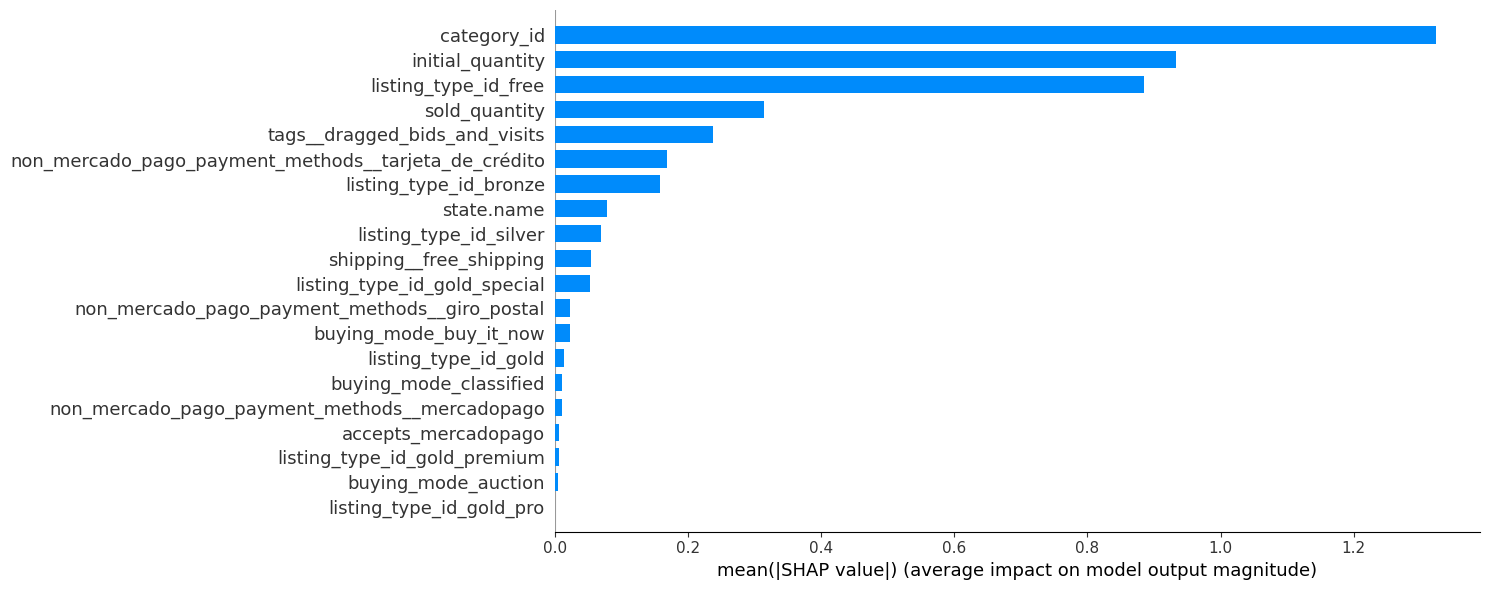

In [9]:
shap.summary_plot(shap_values=shap_values, features=model[:-2].transform(X).sample(1000, random_state=SEED)[X_shap.columns], plot_type="bar", max_display=20, plot_size=(15, 6), class_names=True)

- Ahora veremos el tipo y magnitud de aporte de cada variable a la prediccion

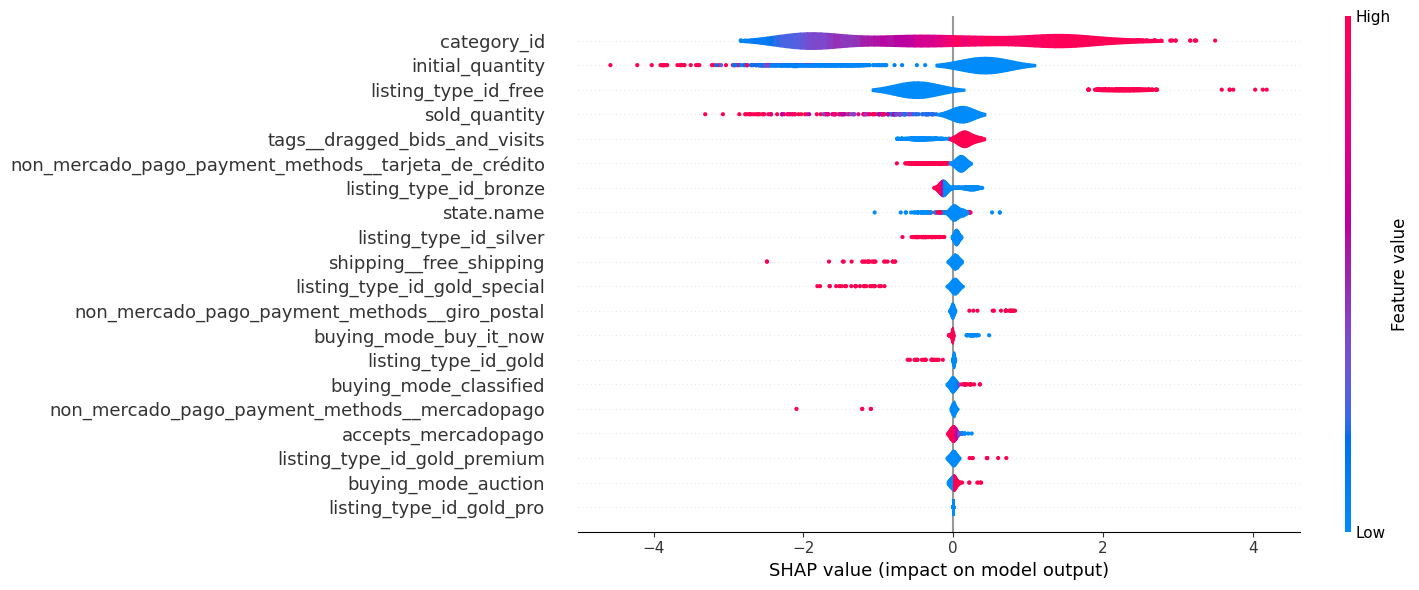

In [10]:
shap.summary_plot(shap_values=shap_values, features=X_shap, plot_type="violin", max_display=20, plot_size=(15, 6), class_names=True)

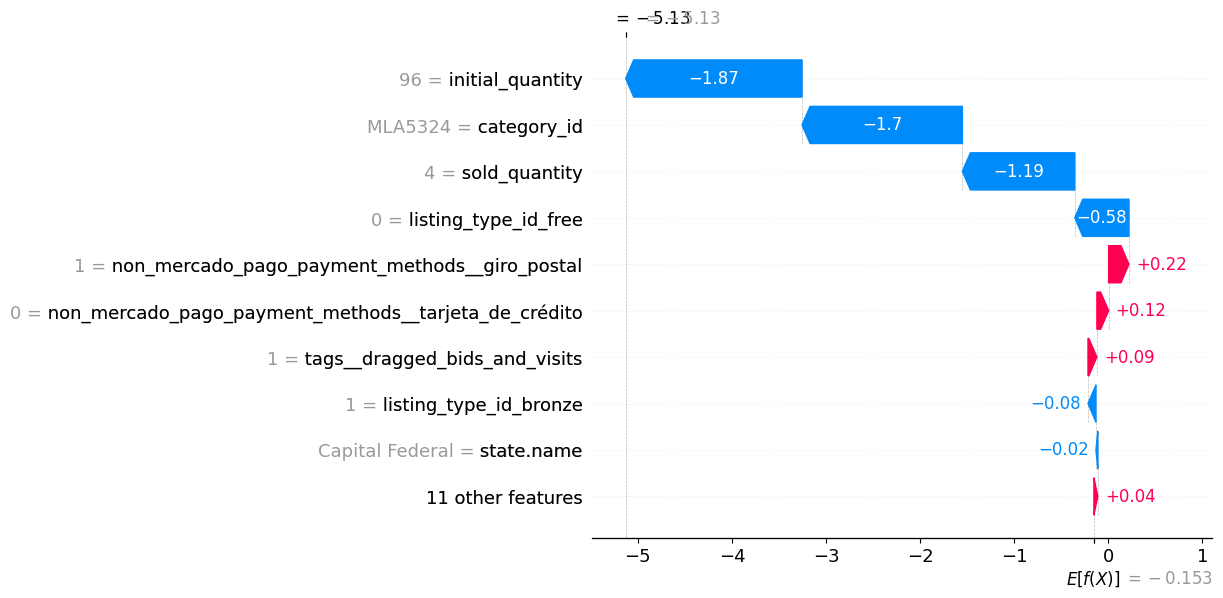

In [11]:
shap.plots.waterfall(shap_values=explanation[0, :])

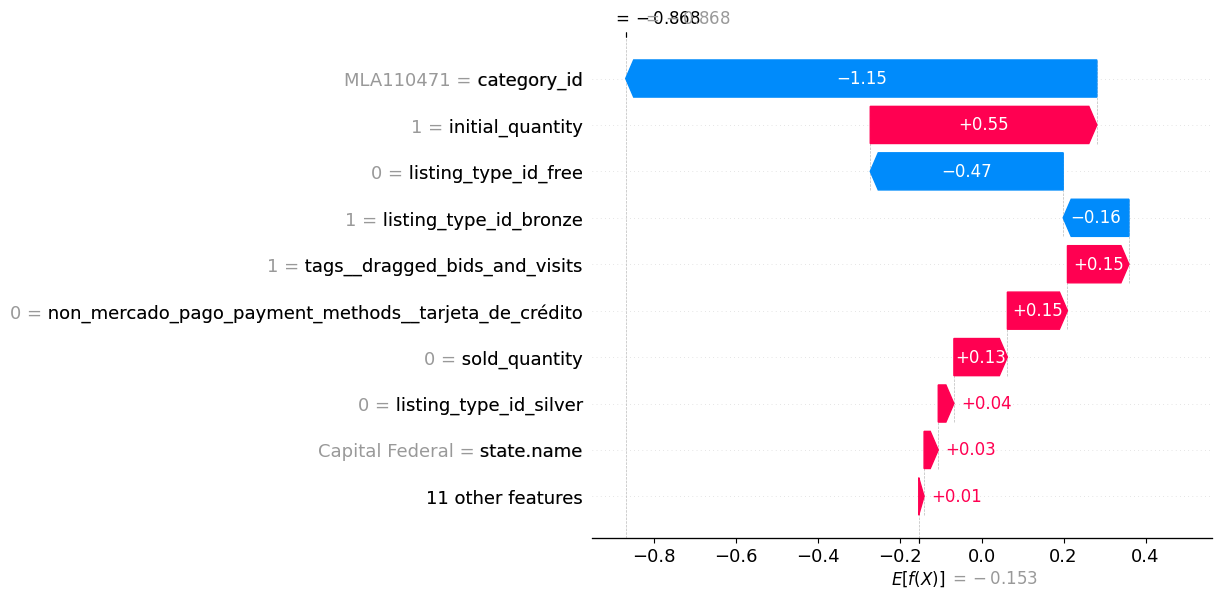

In [12]:
shap.plots.waterfall(shap_values=explanation[1, :])

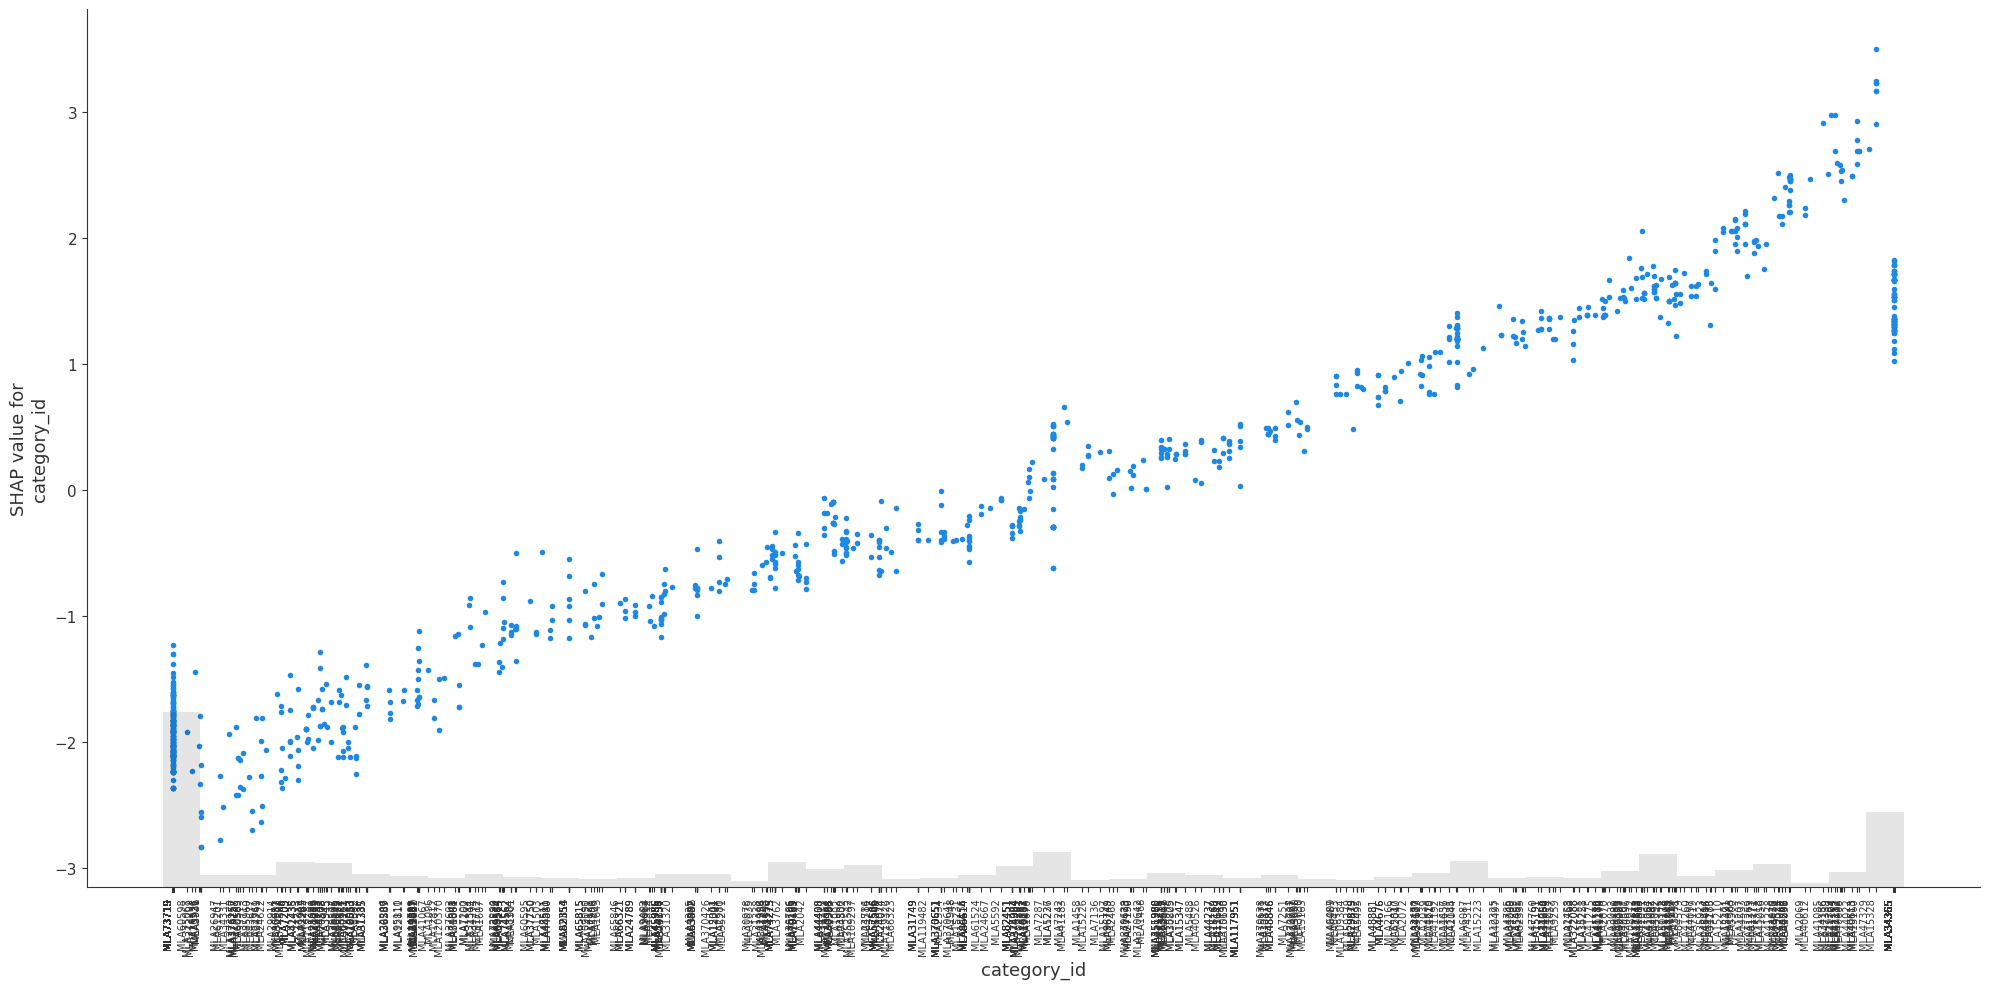

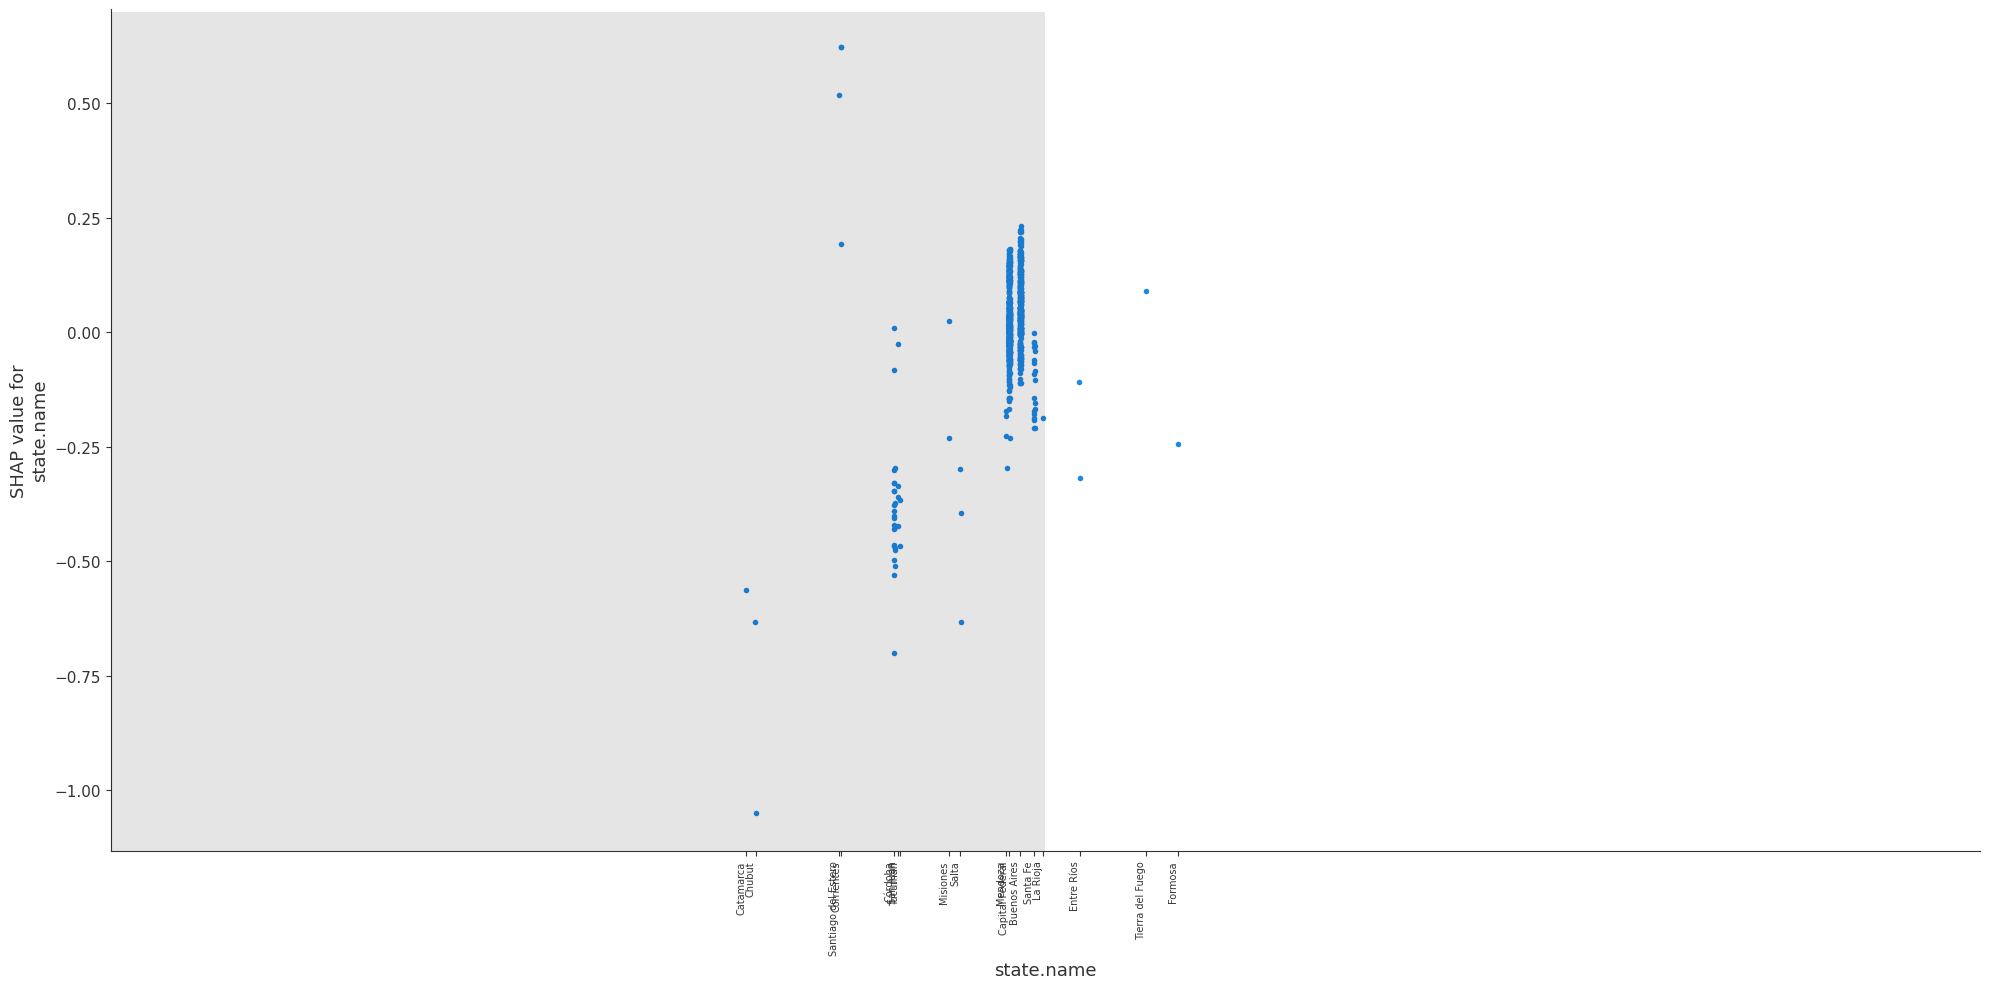

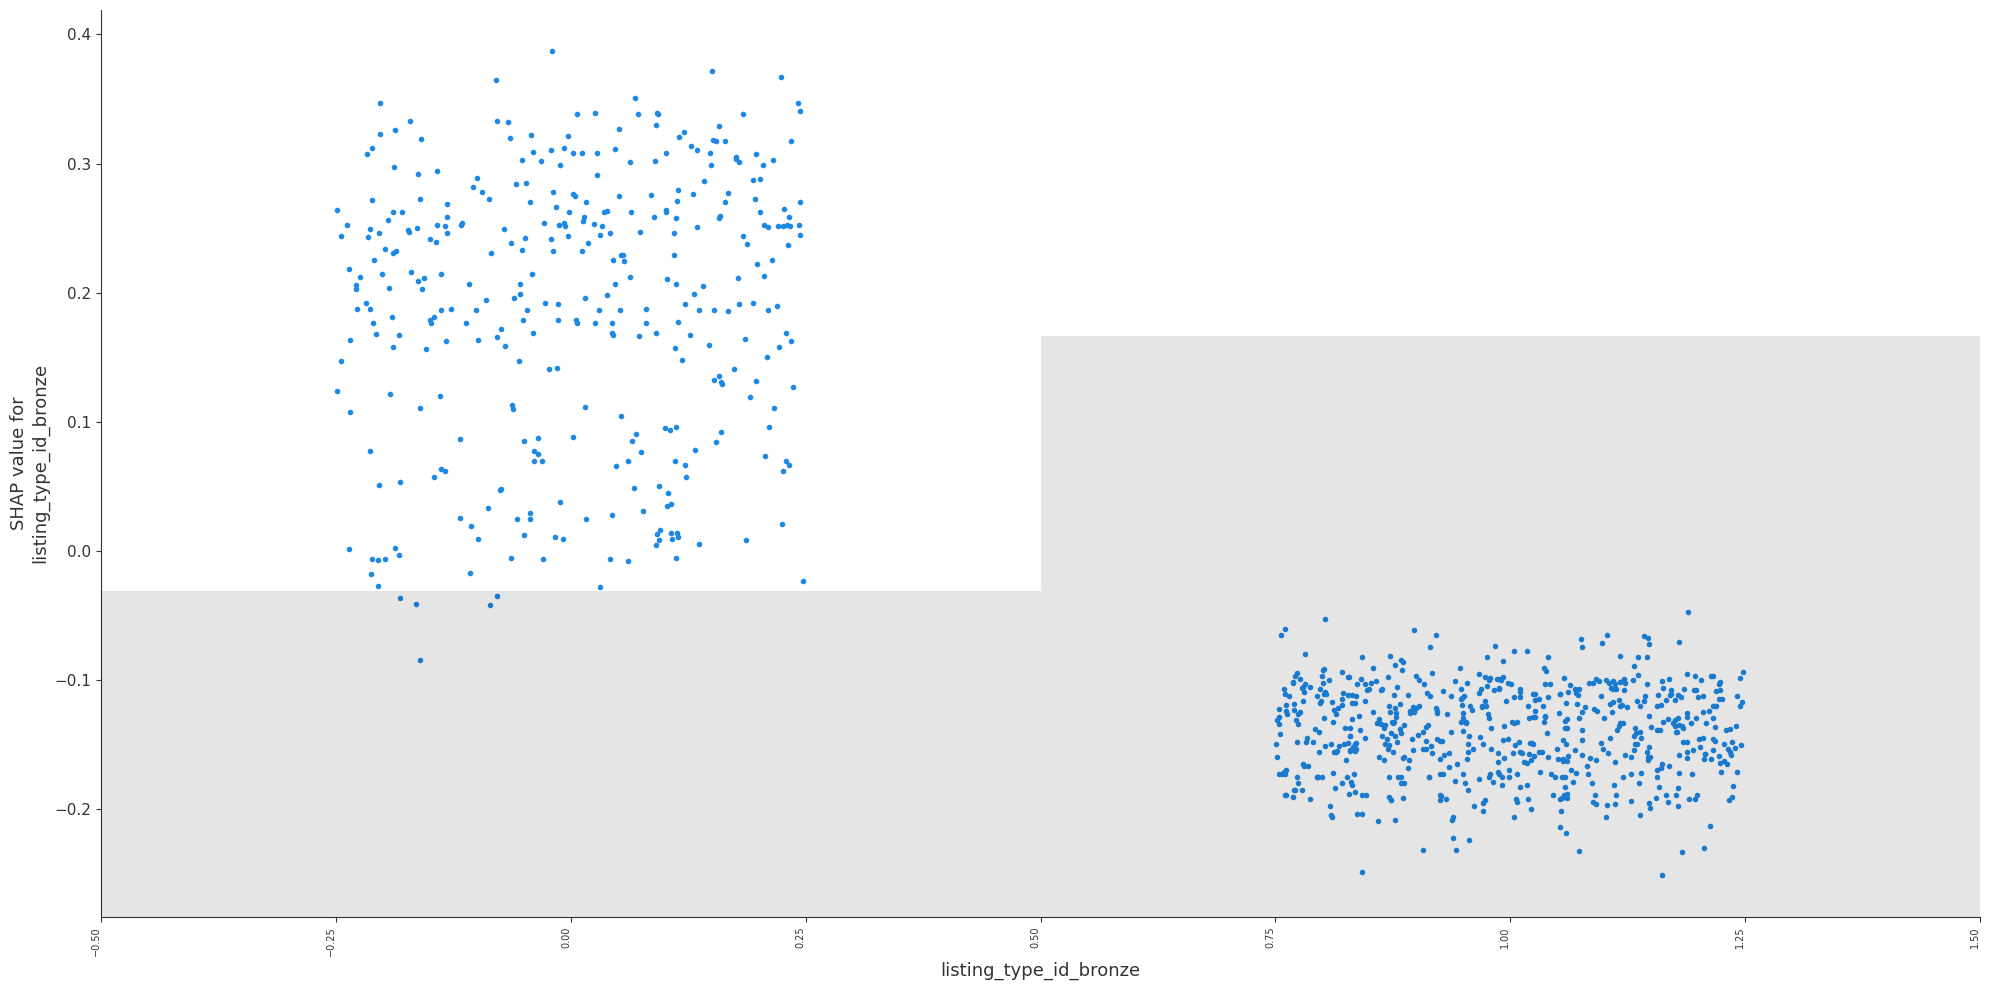

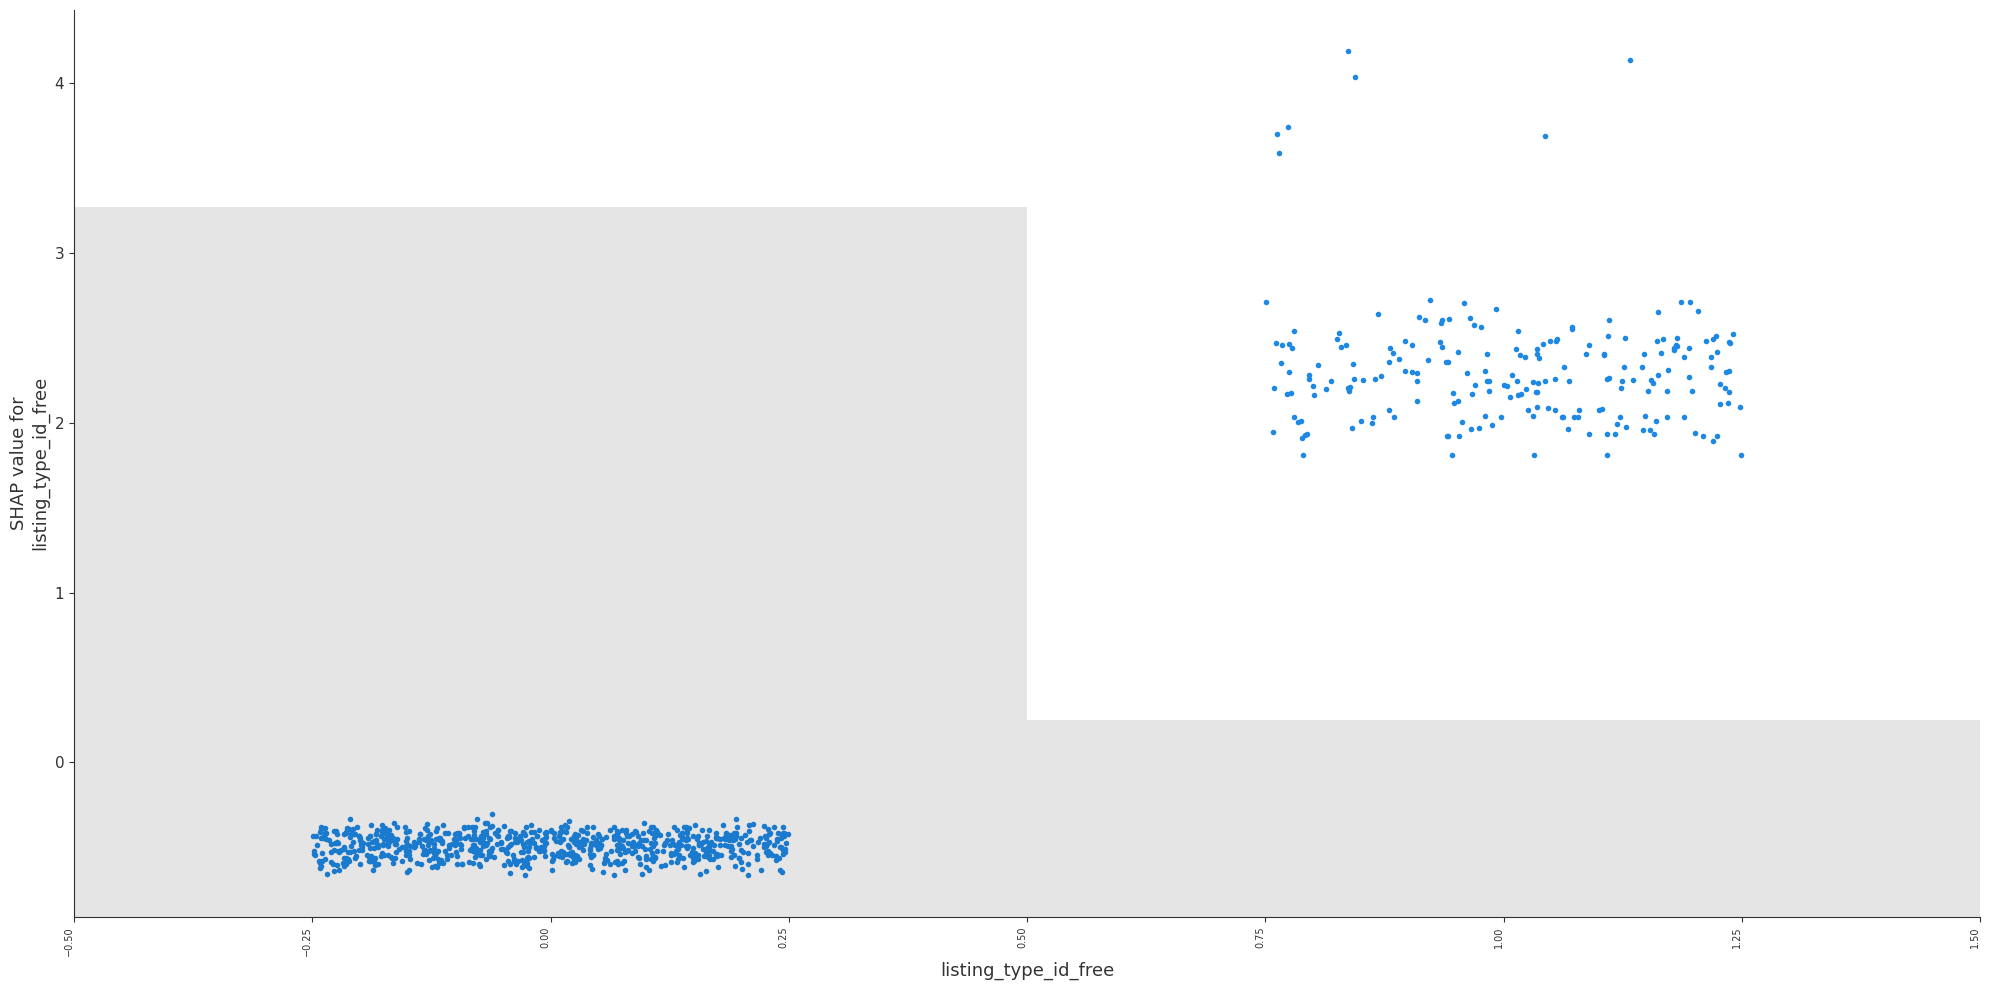

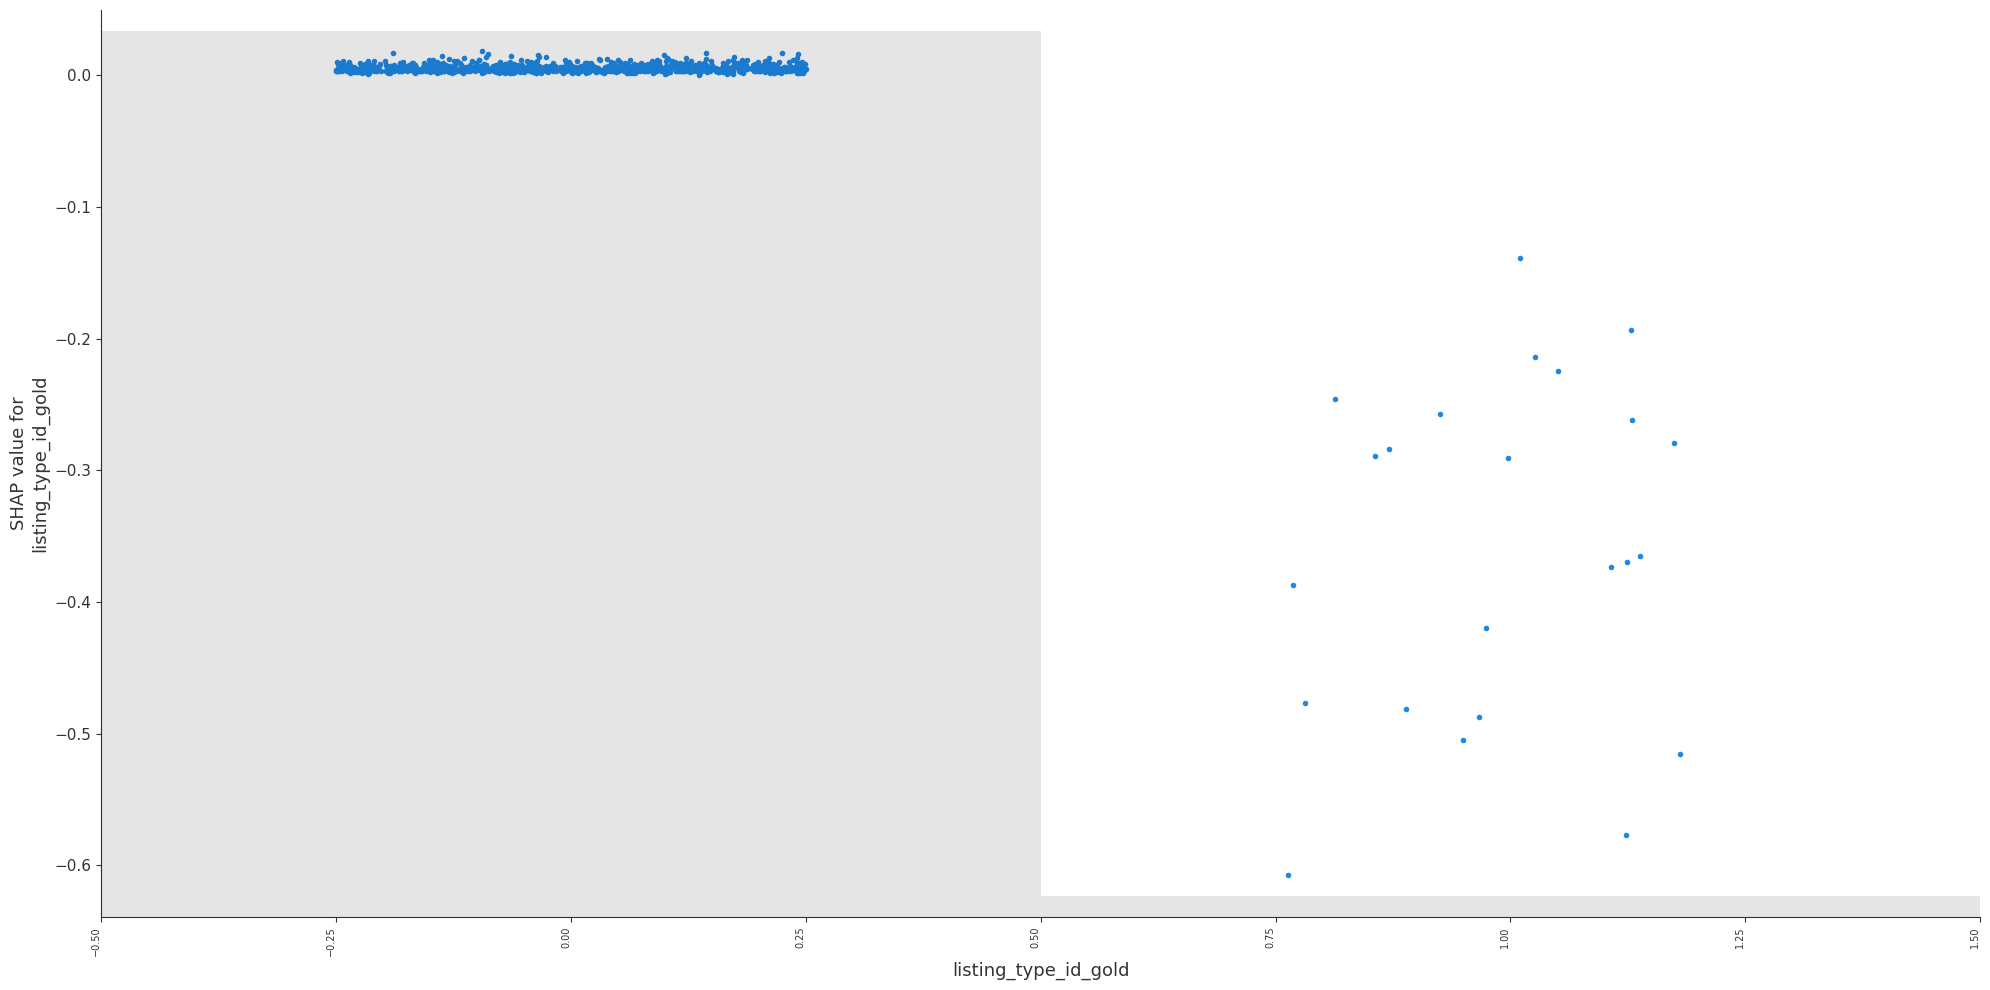

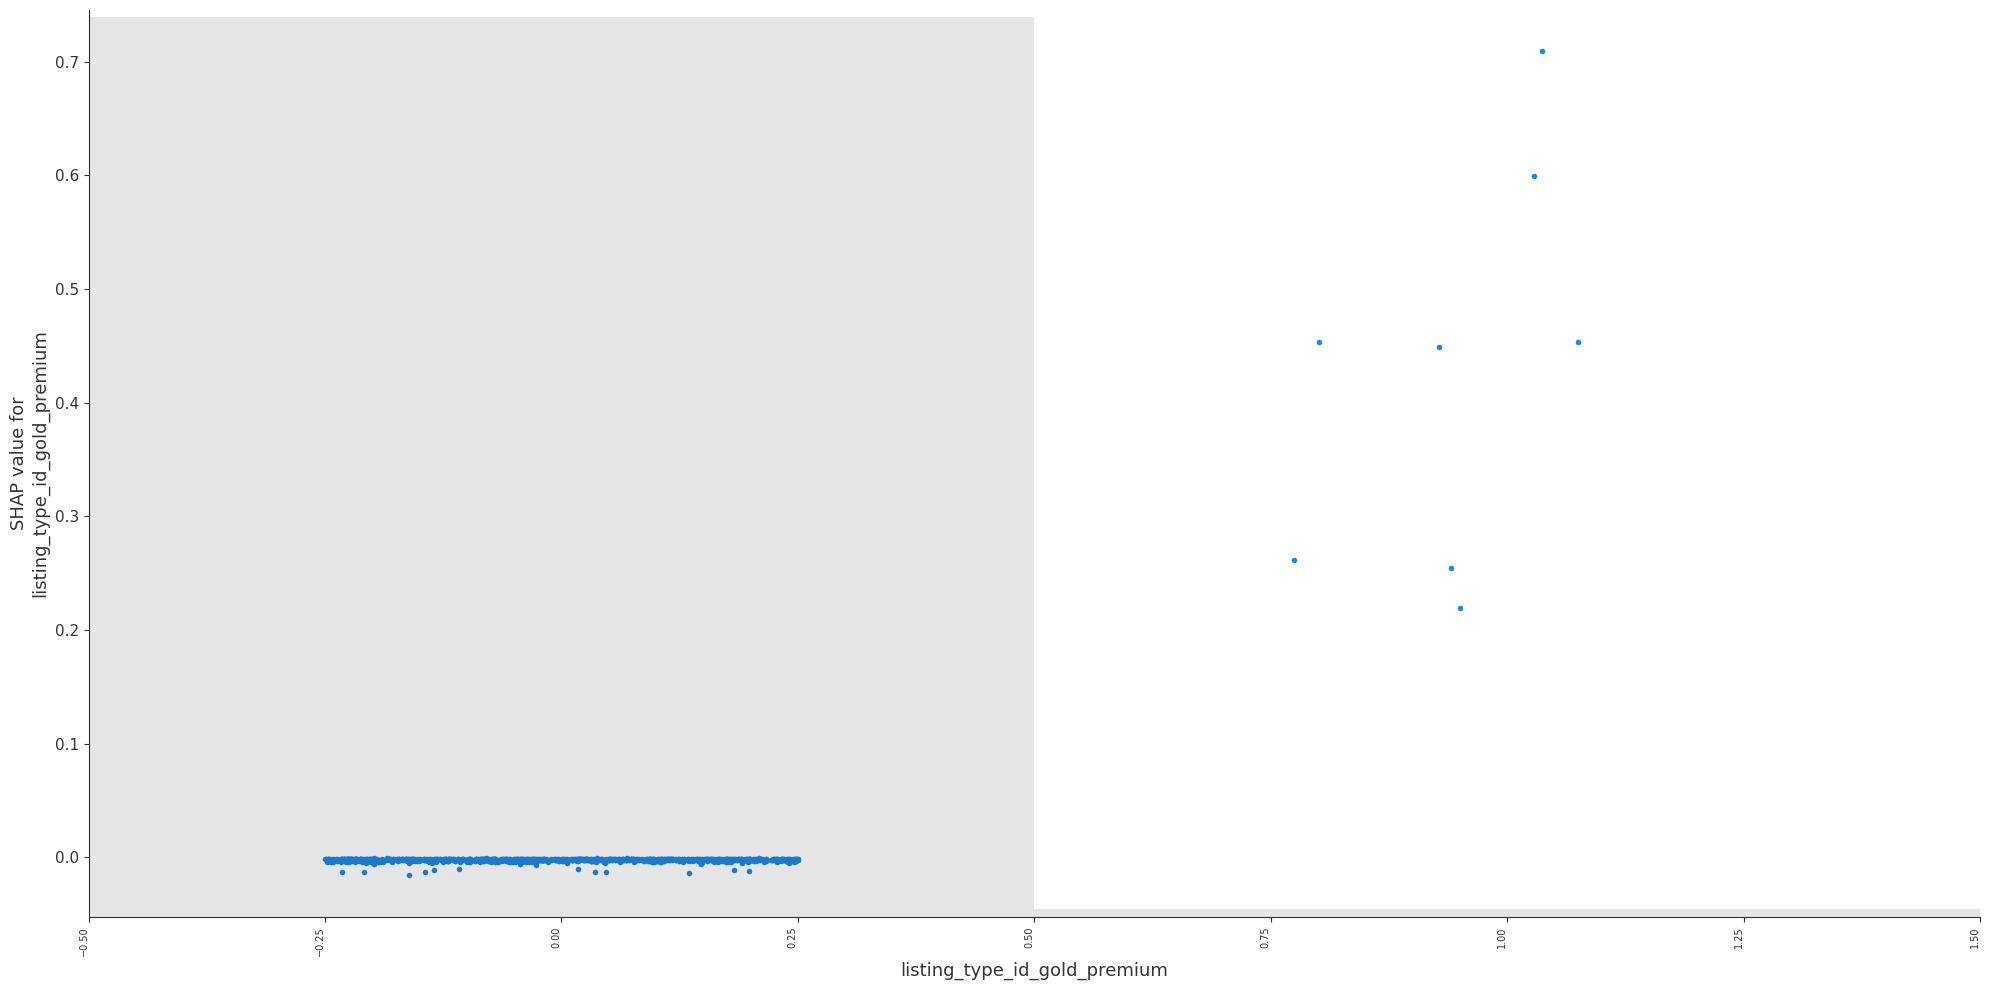

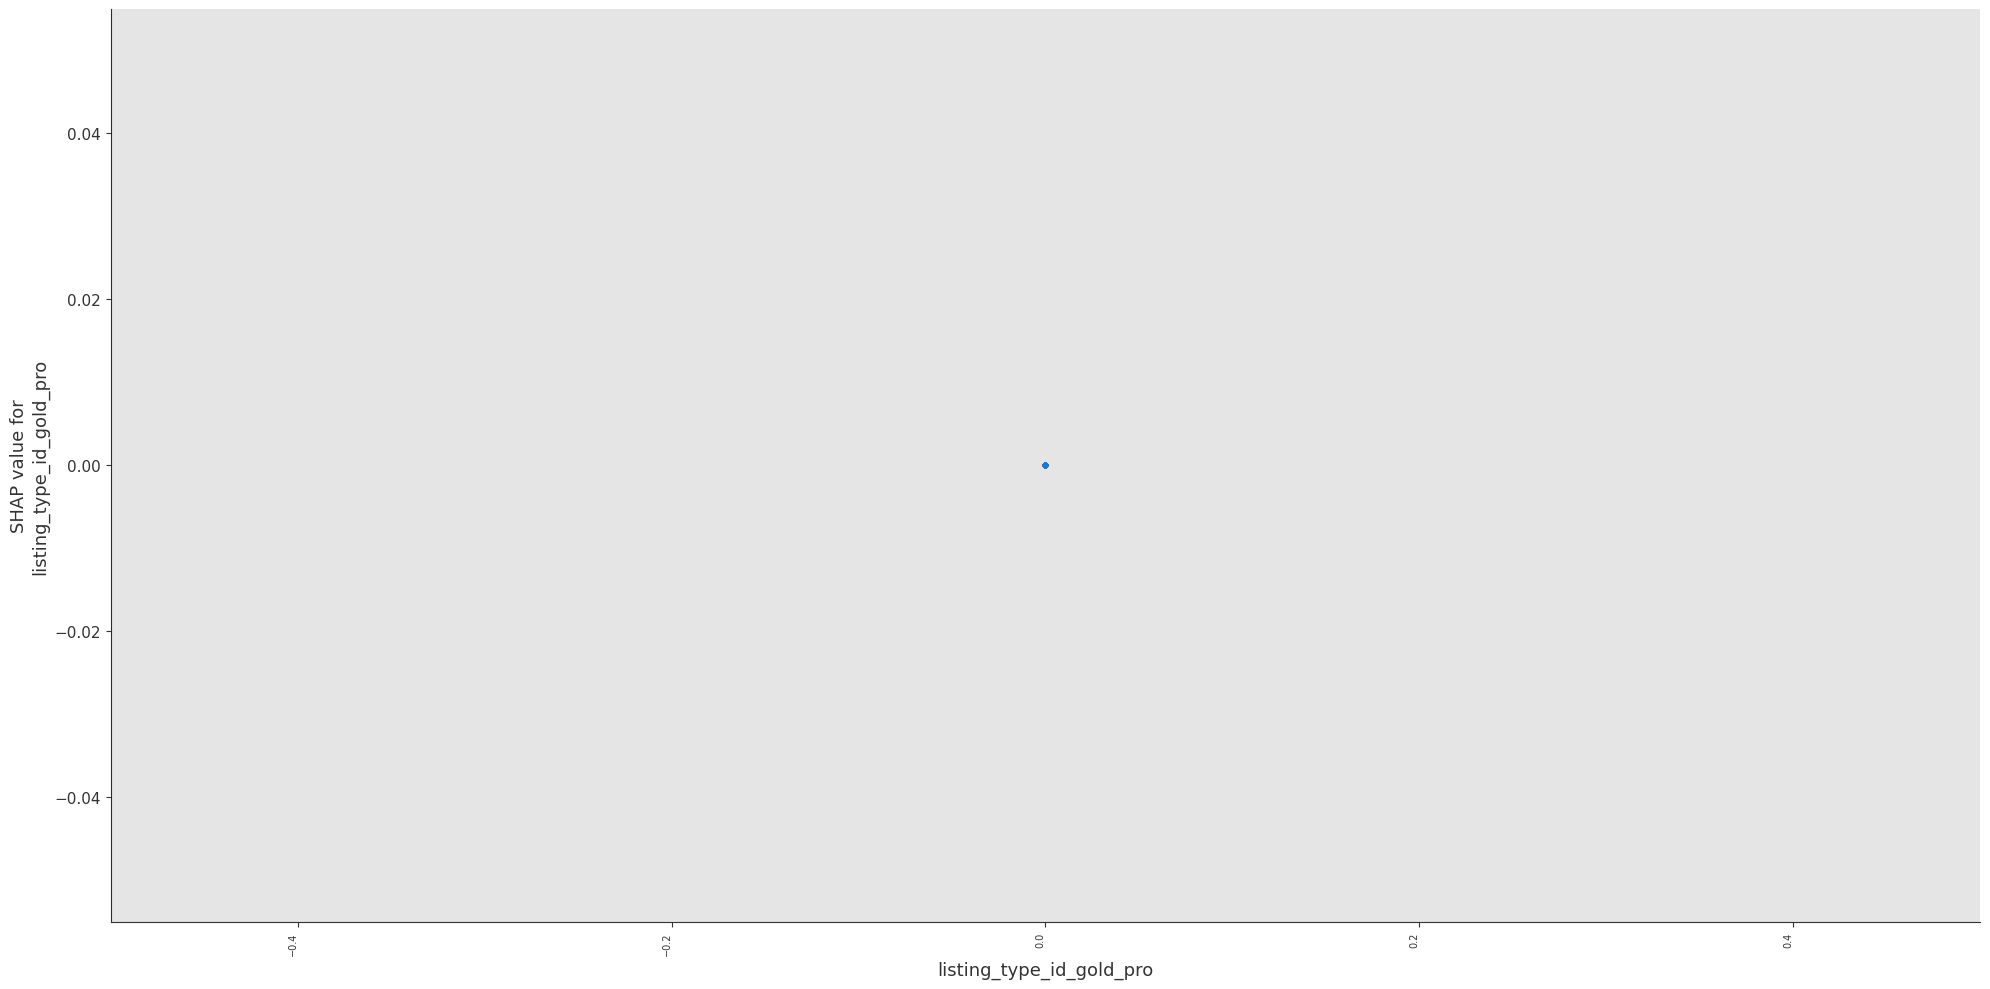

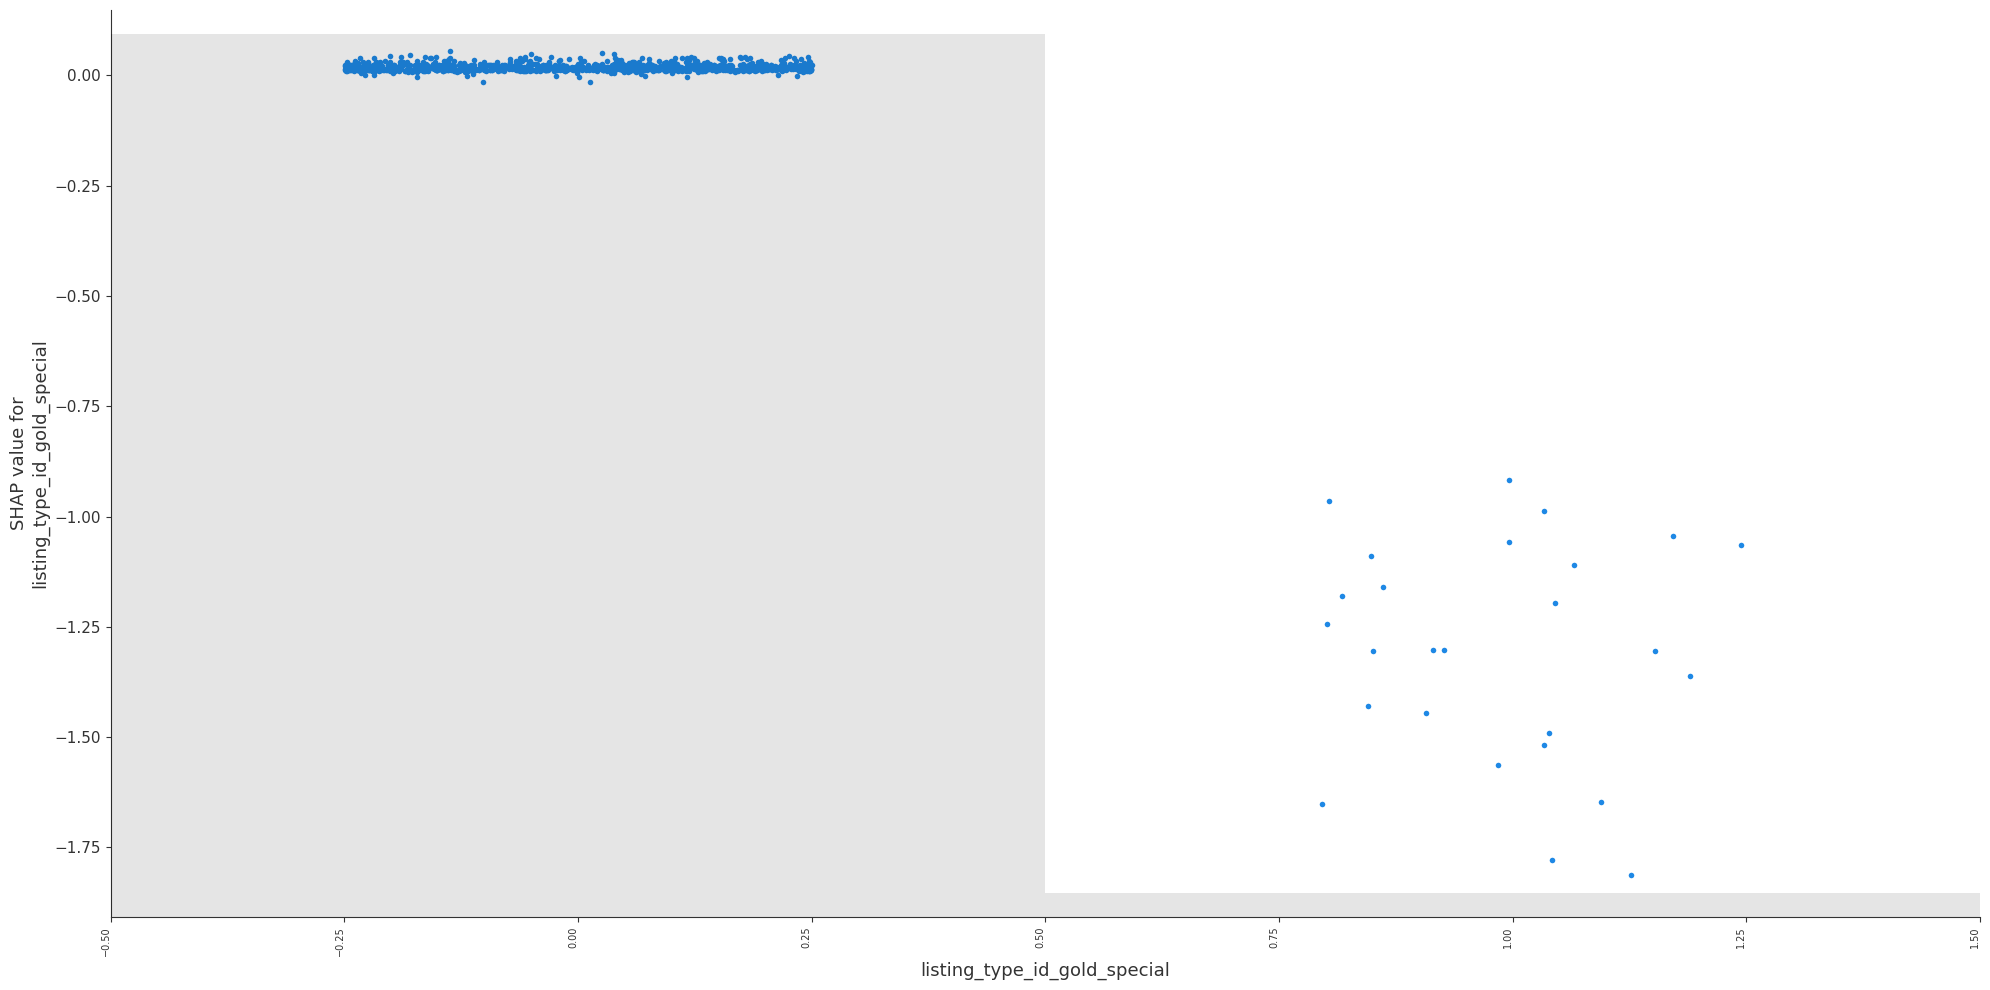

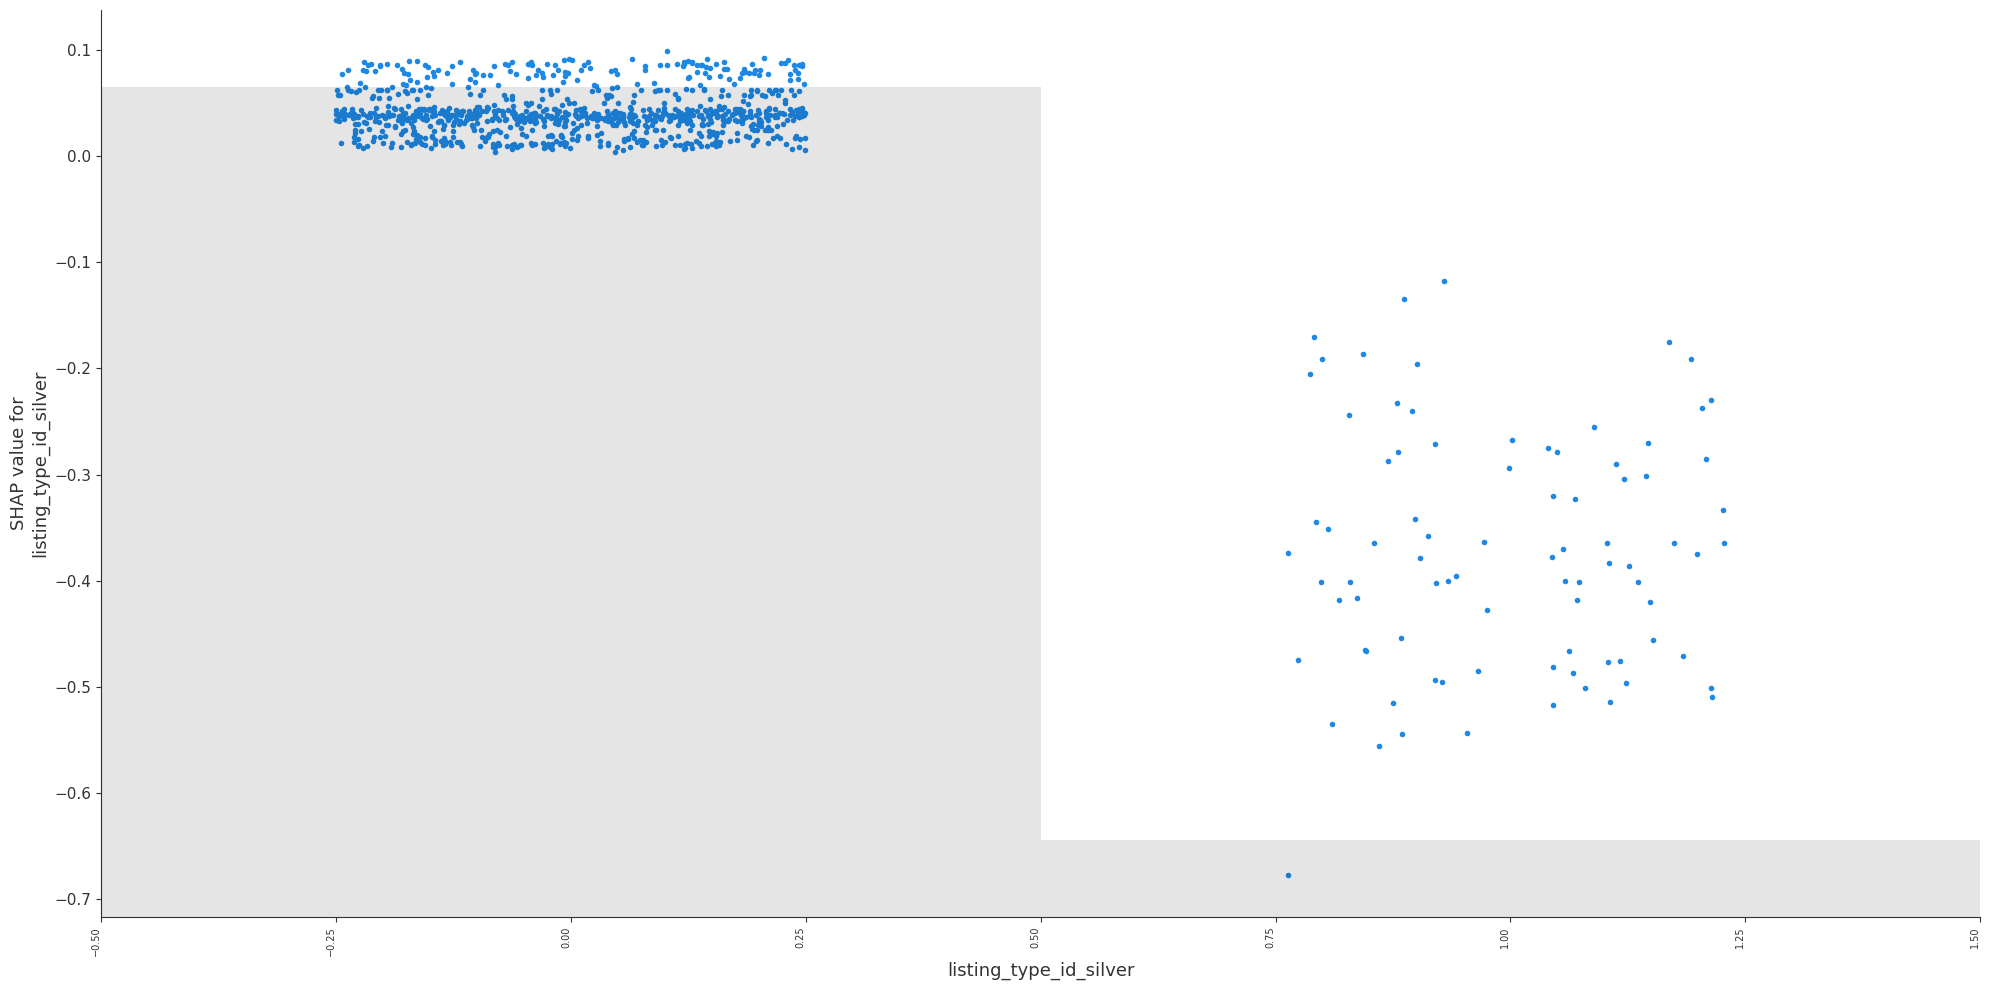

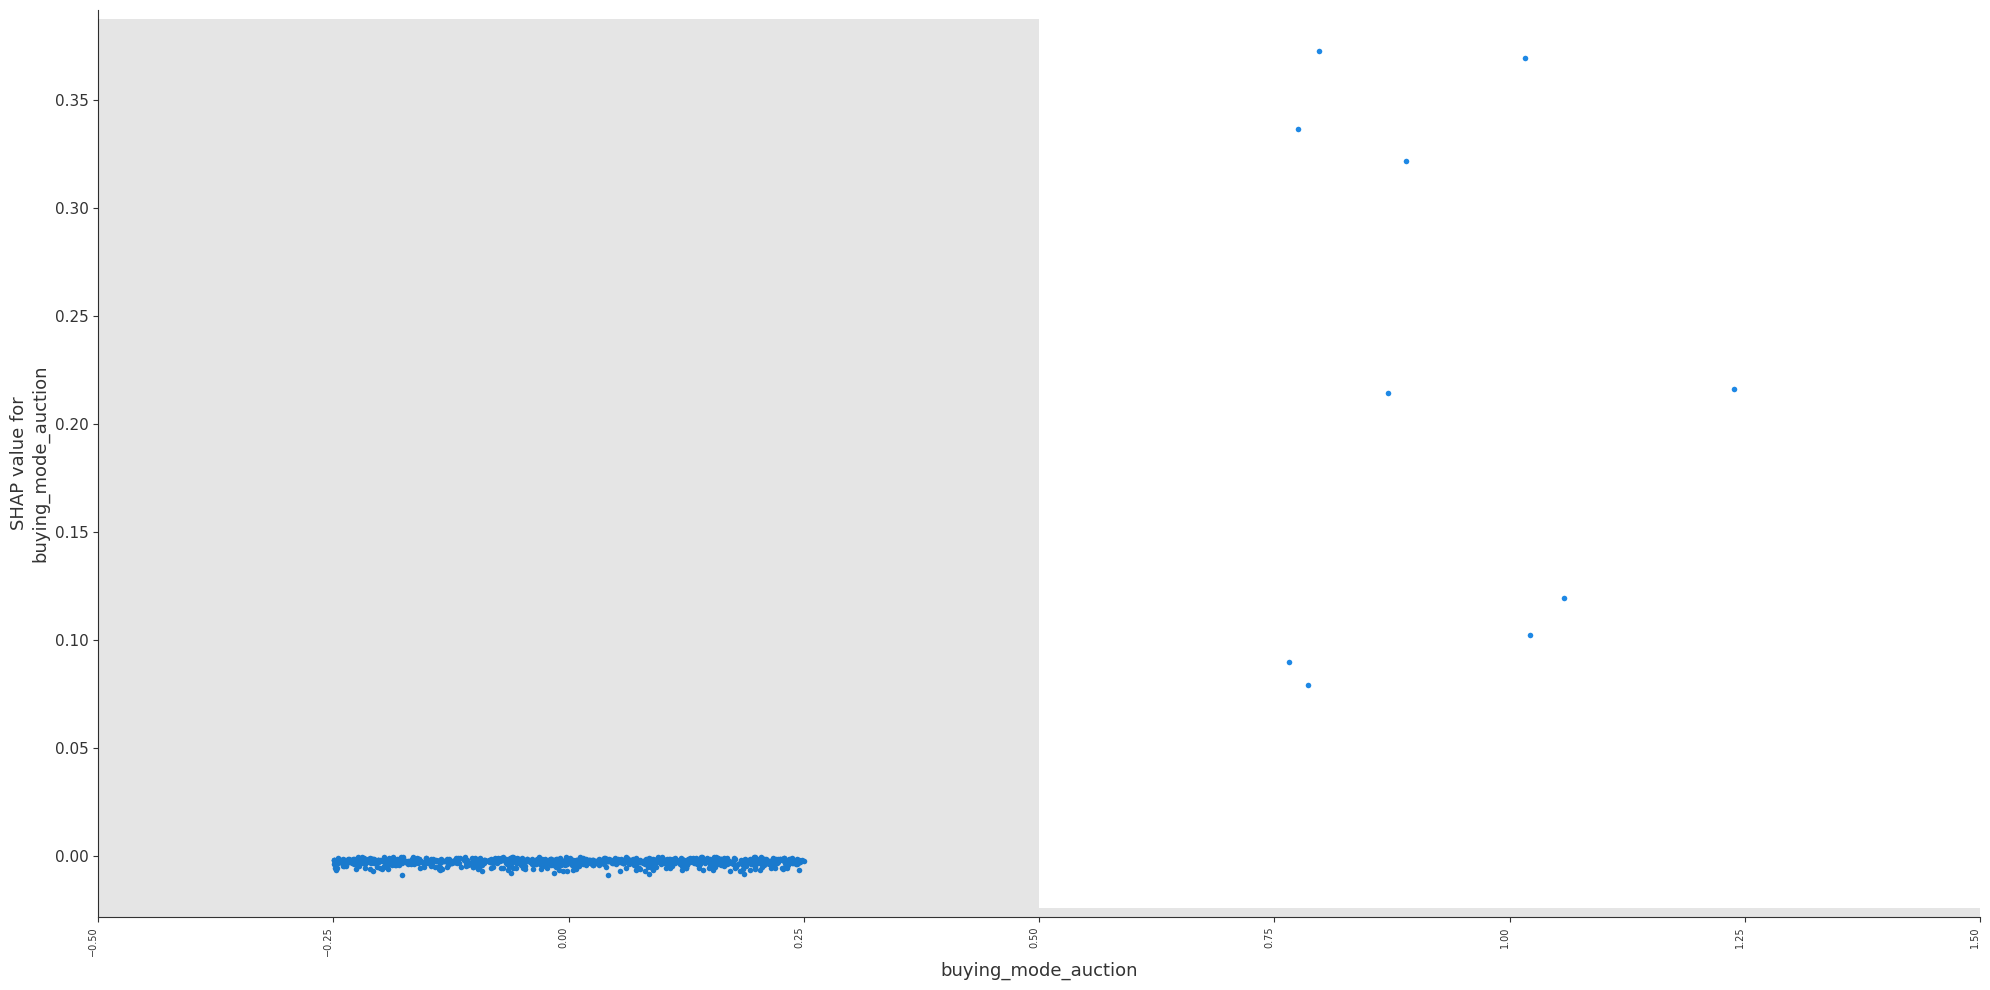

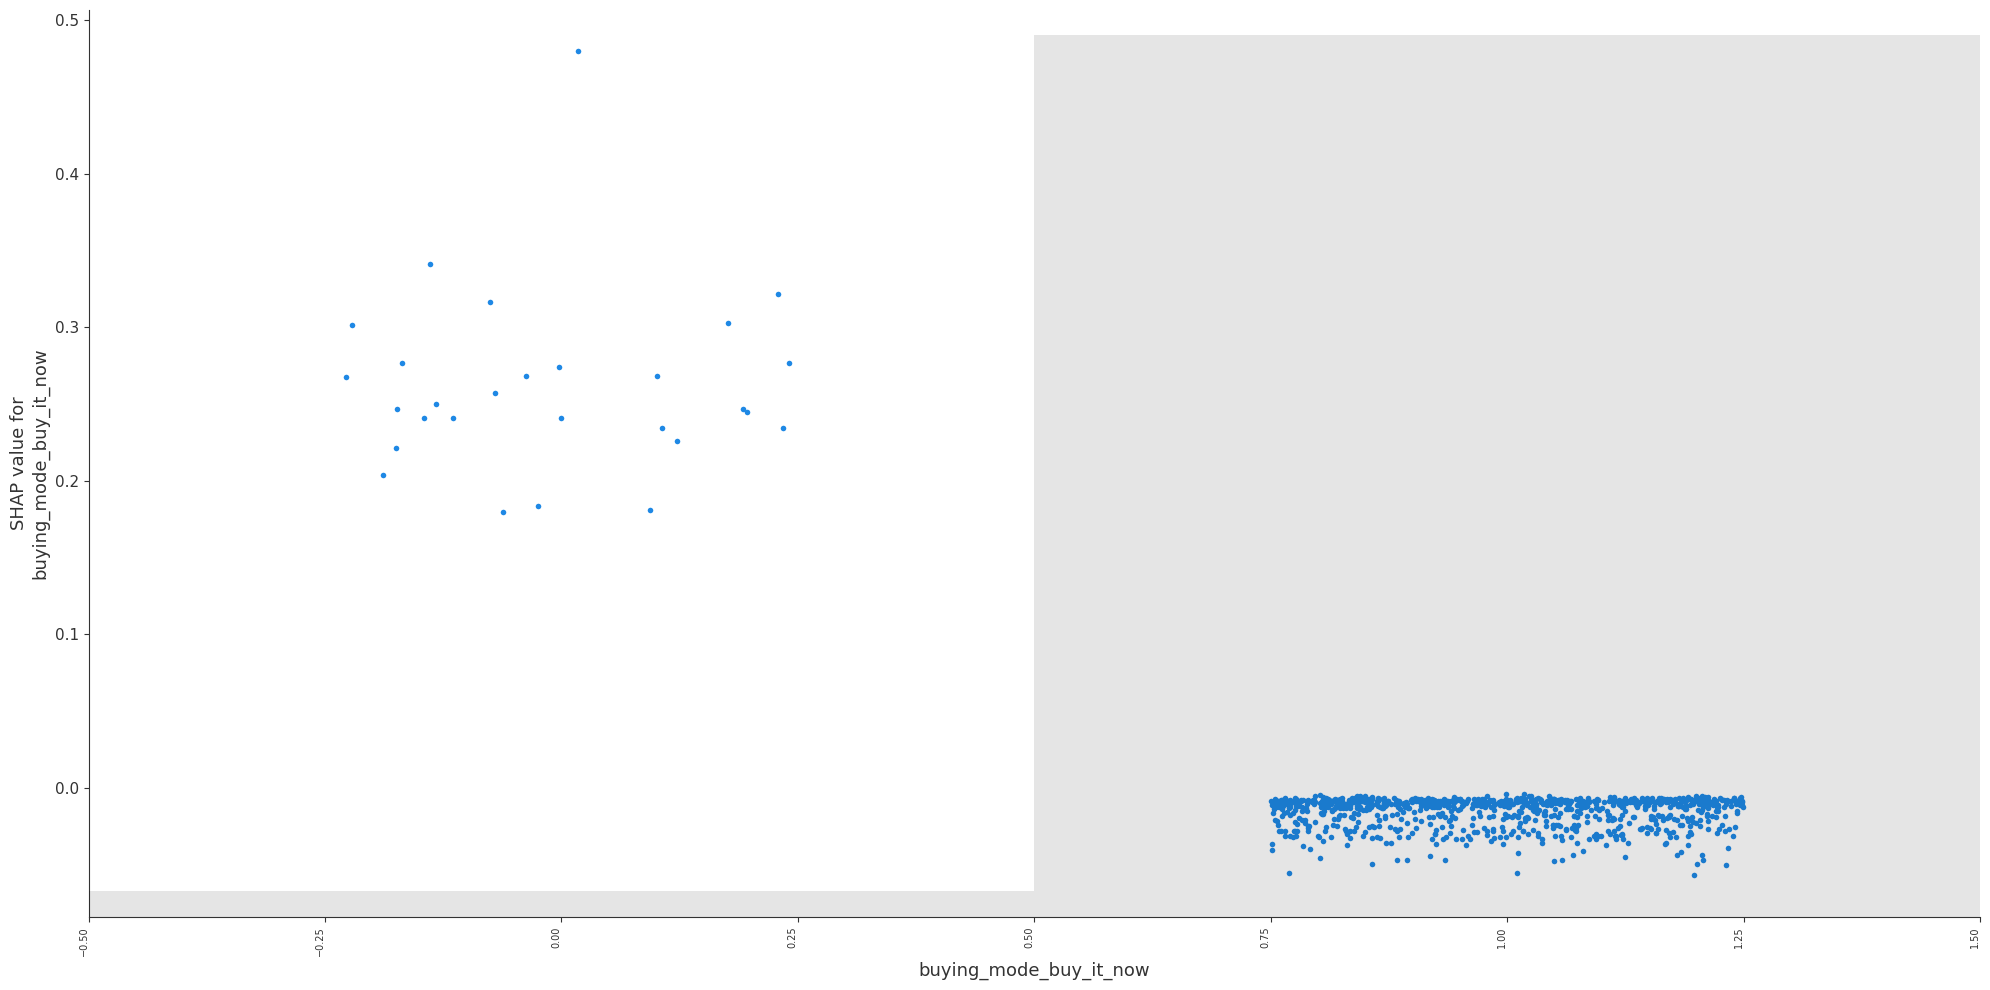

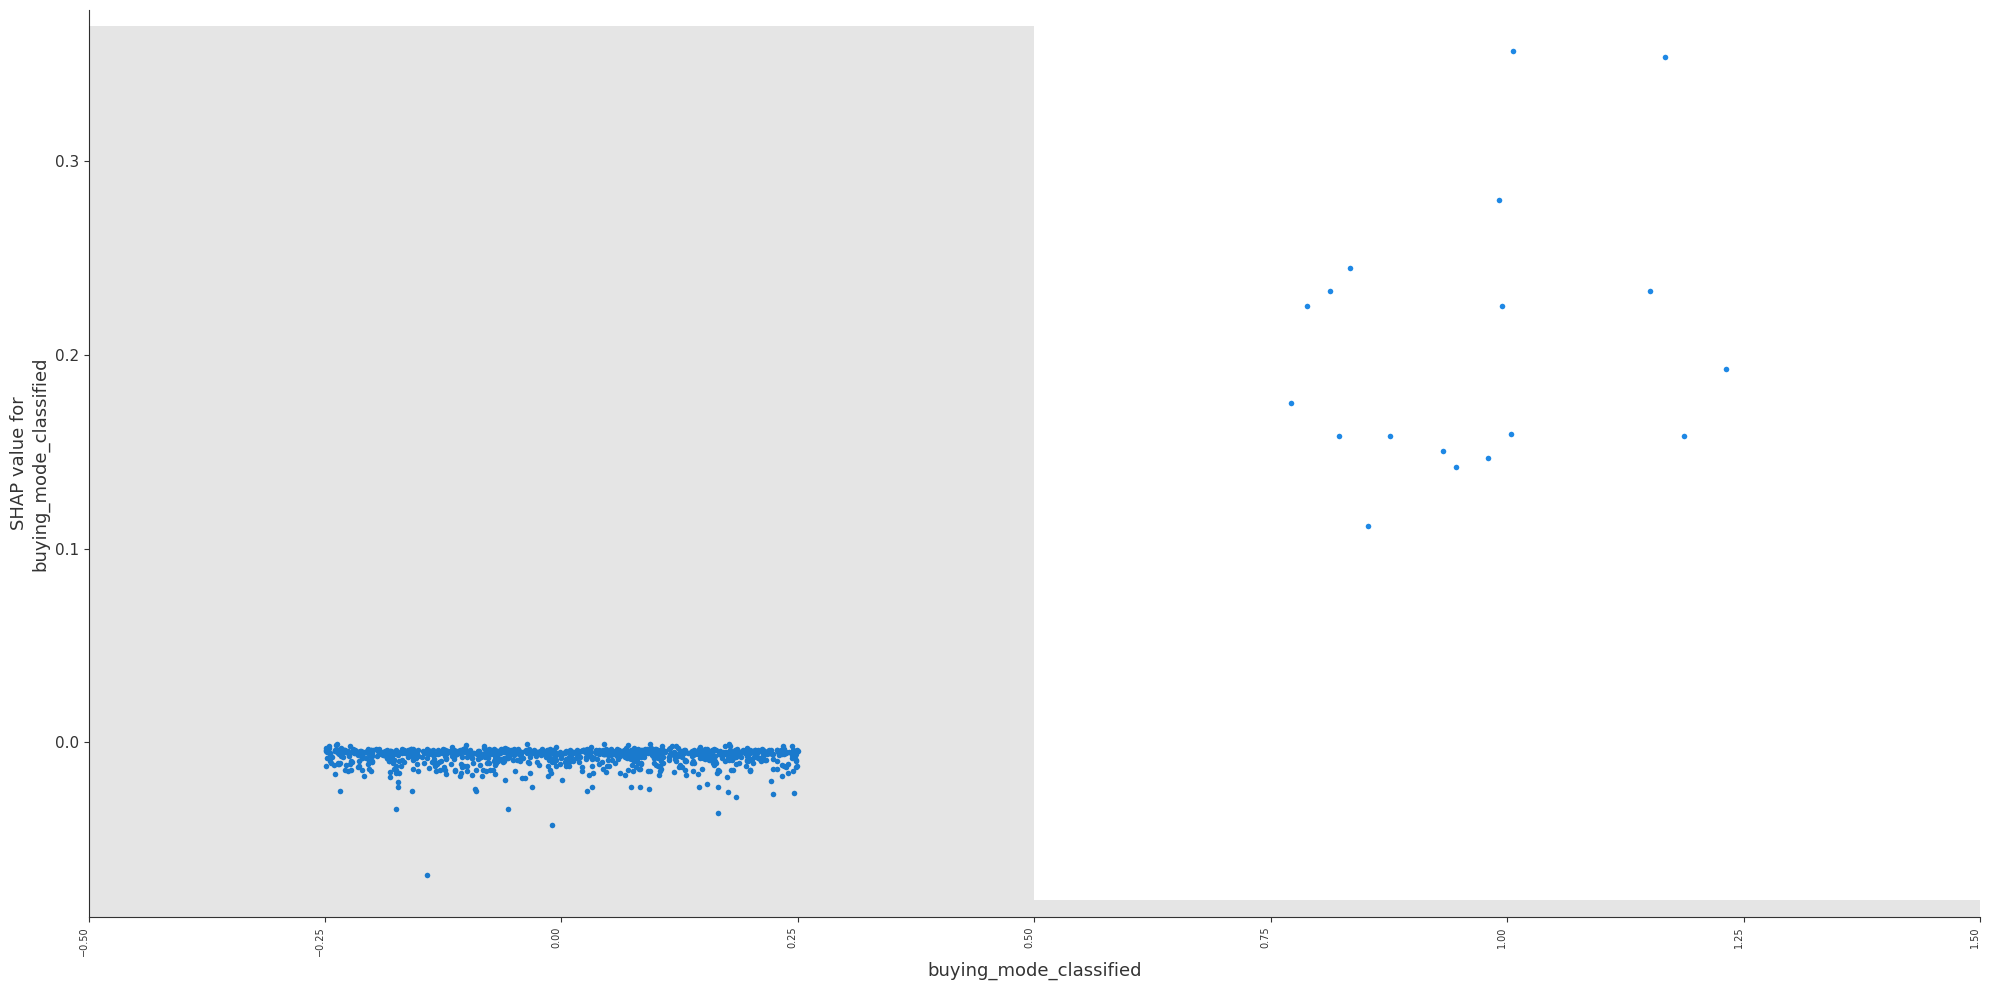

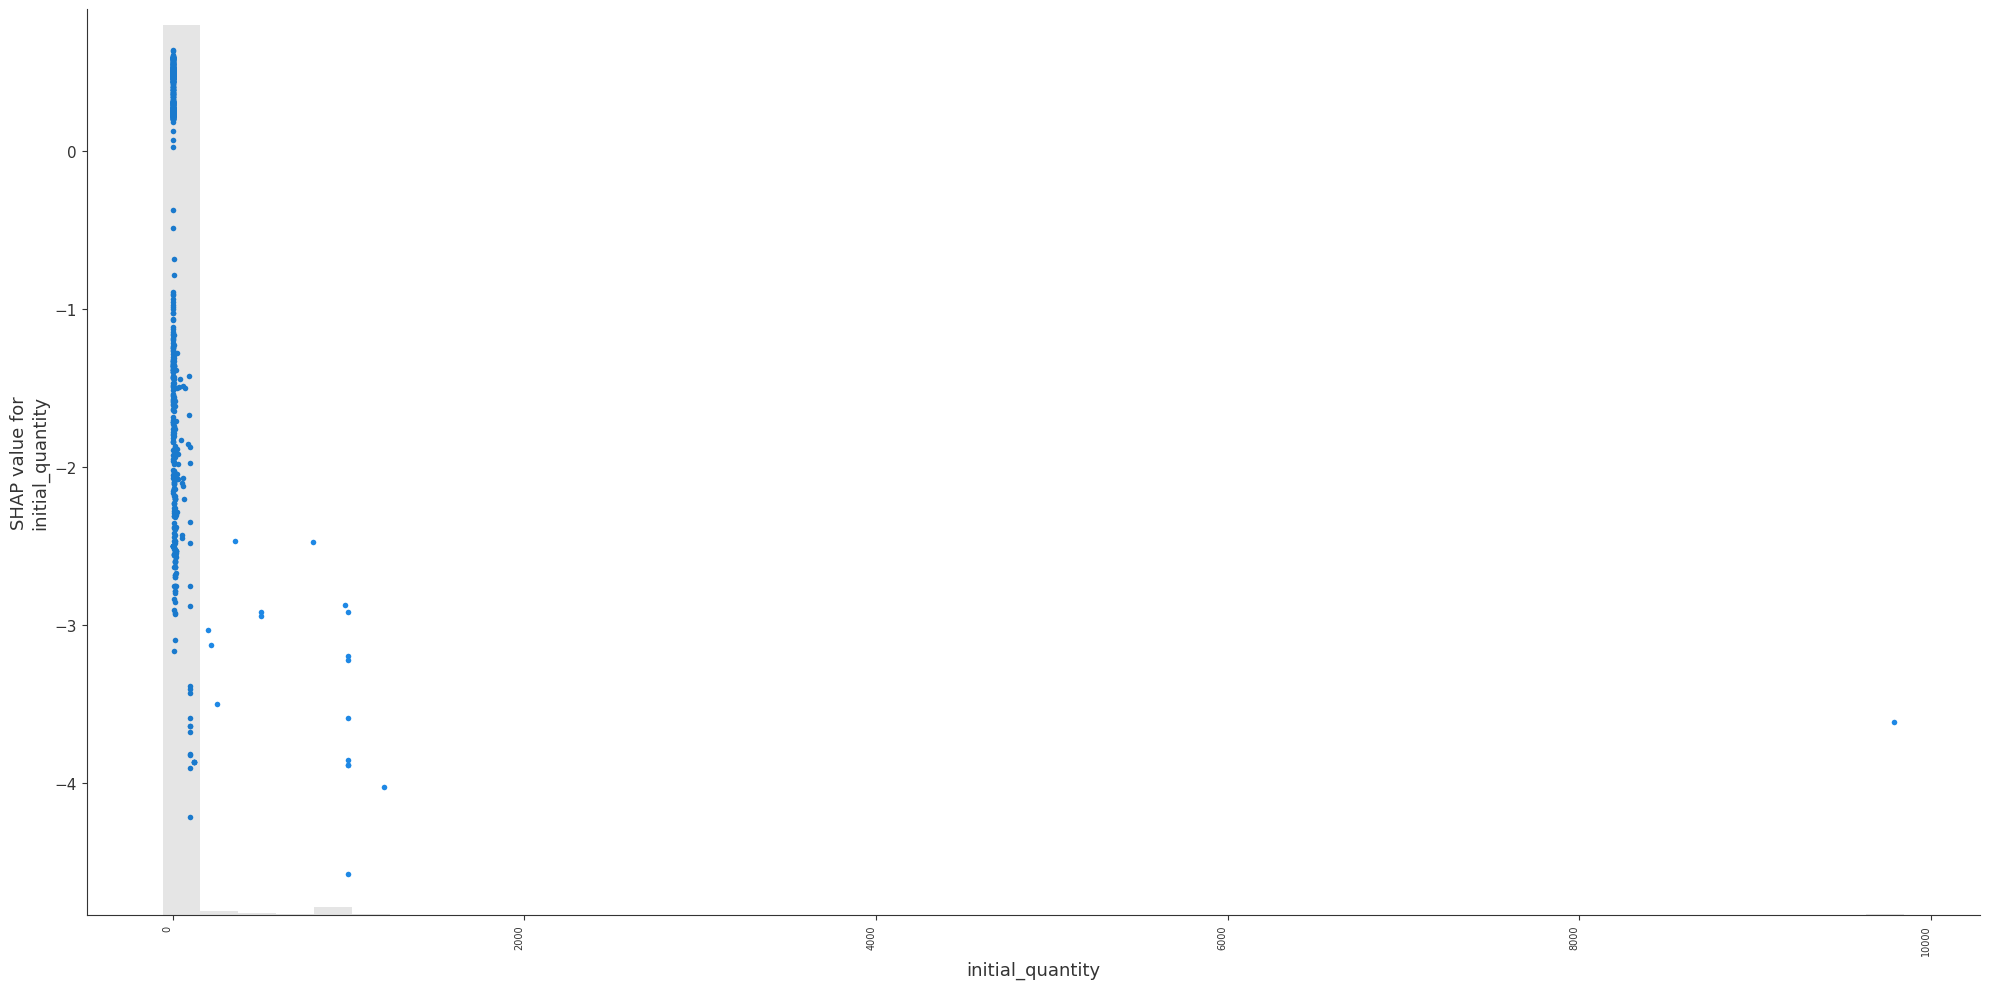

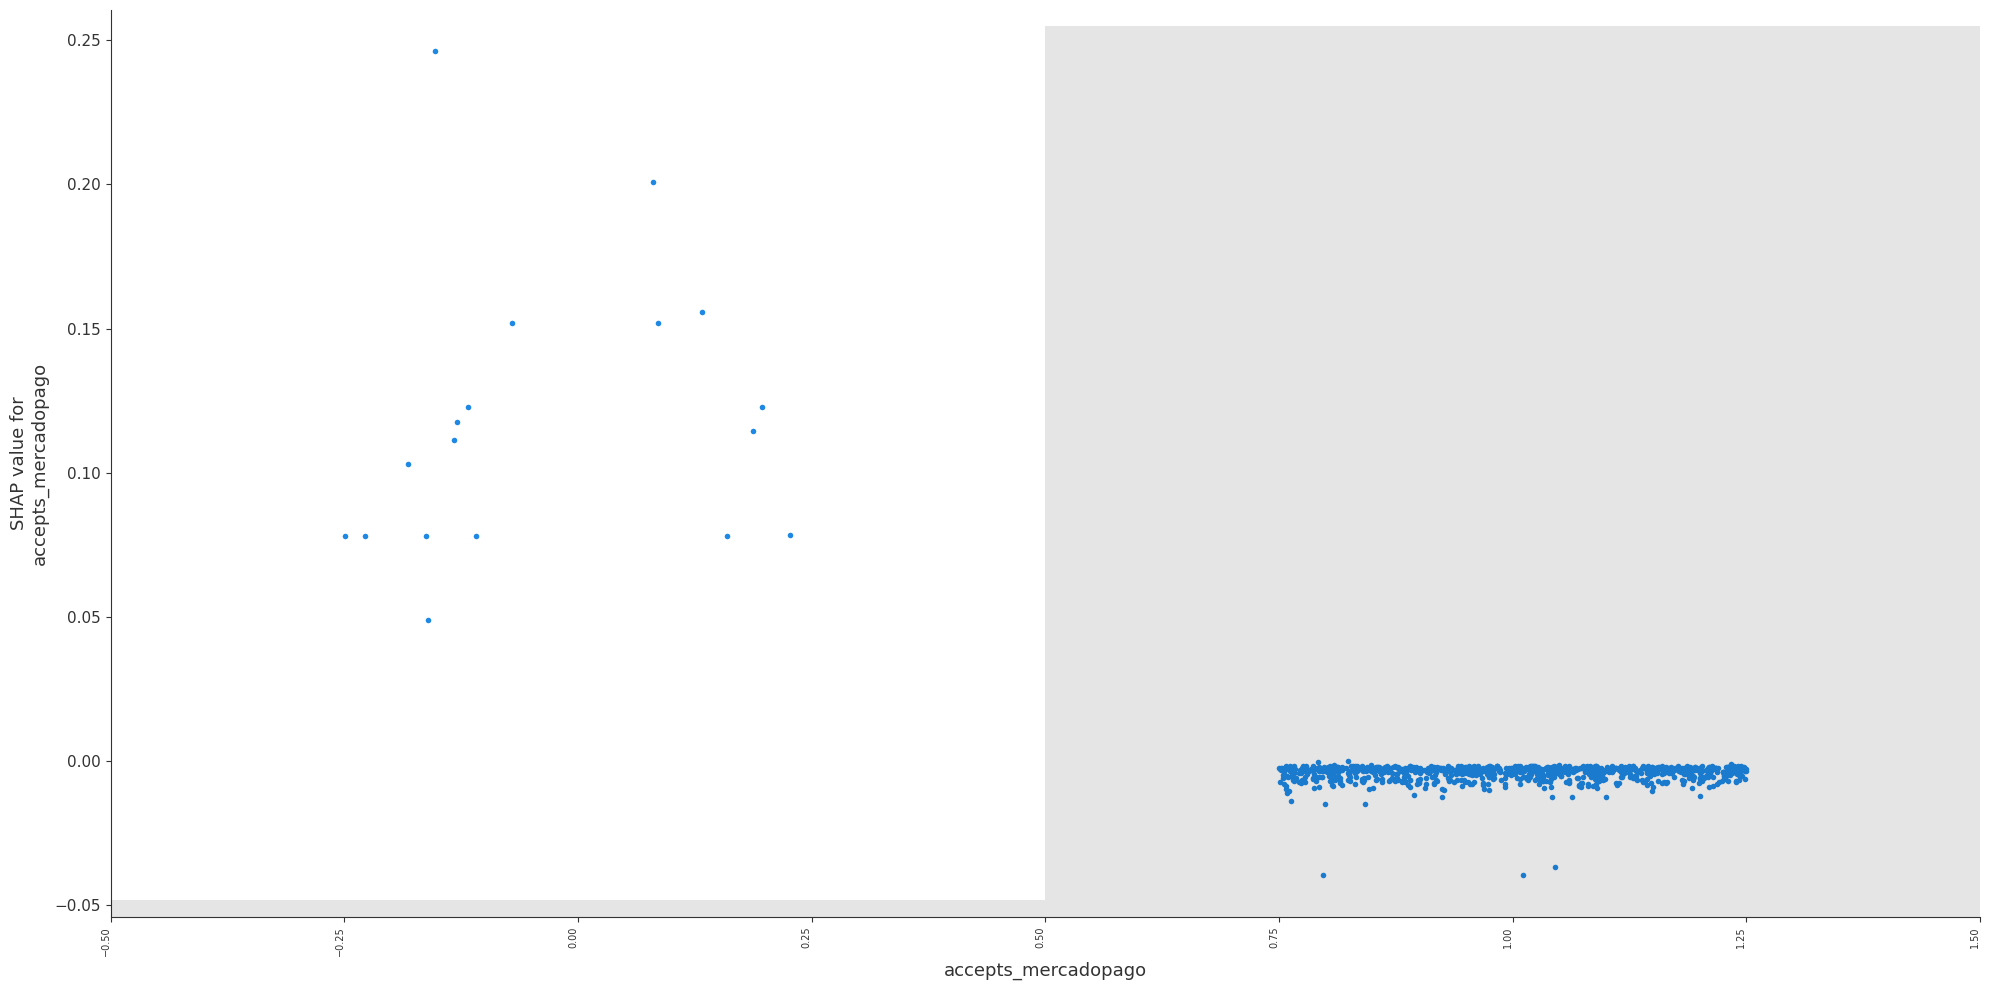

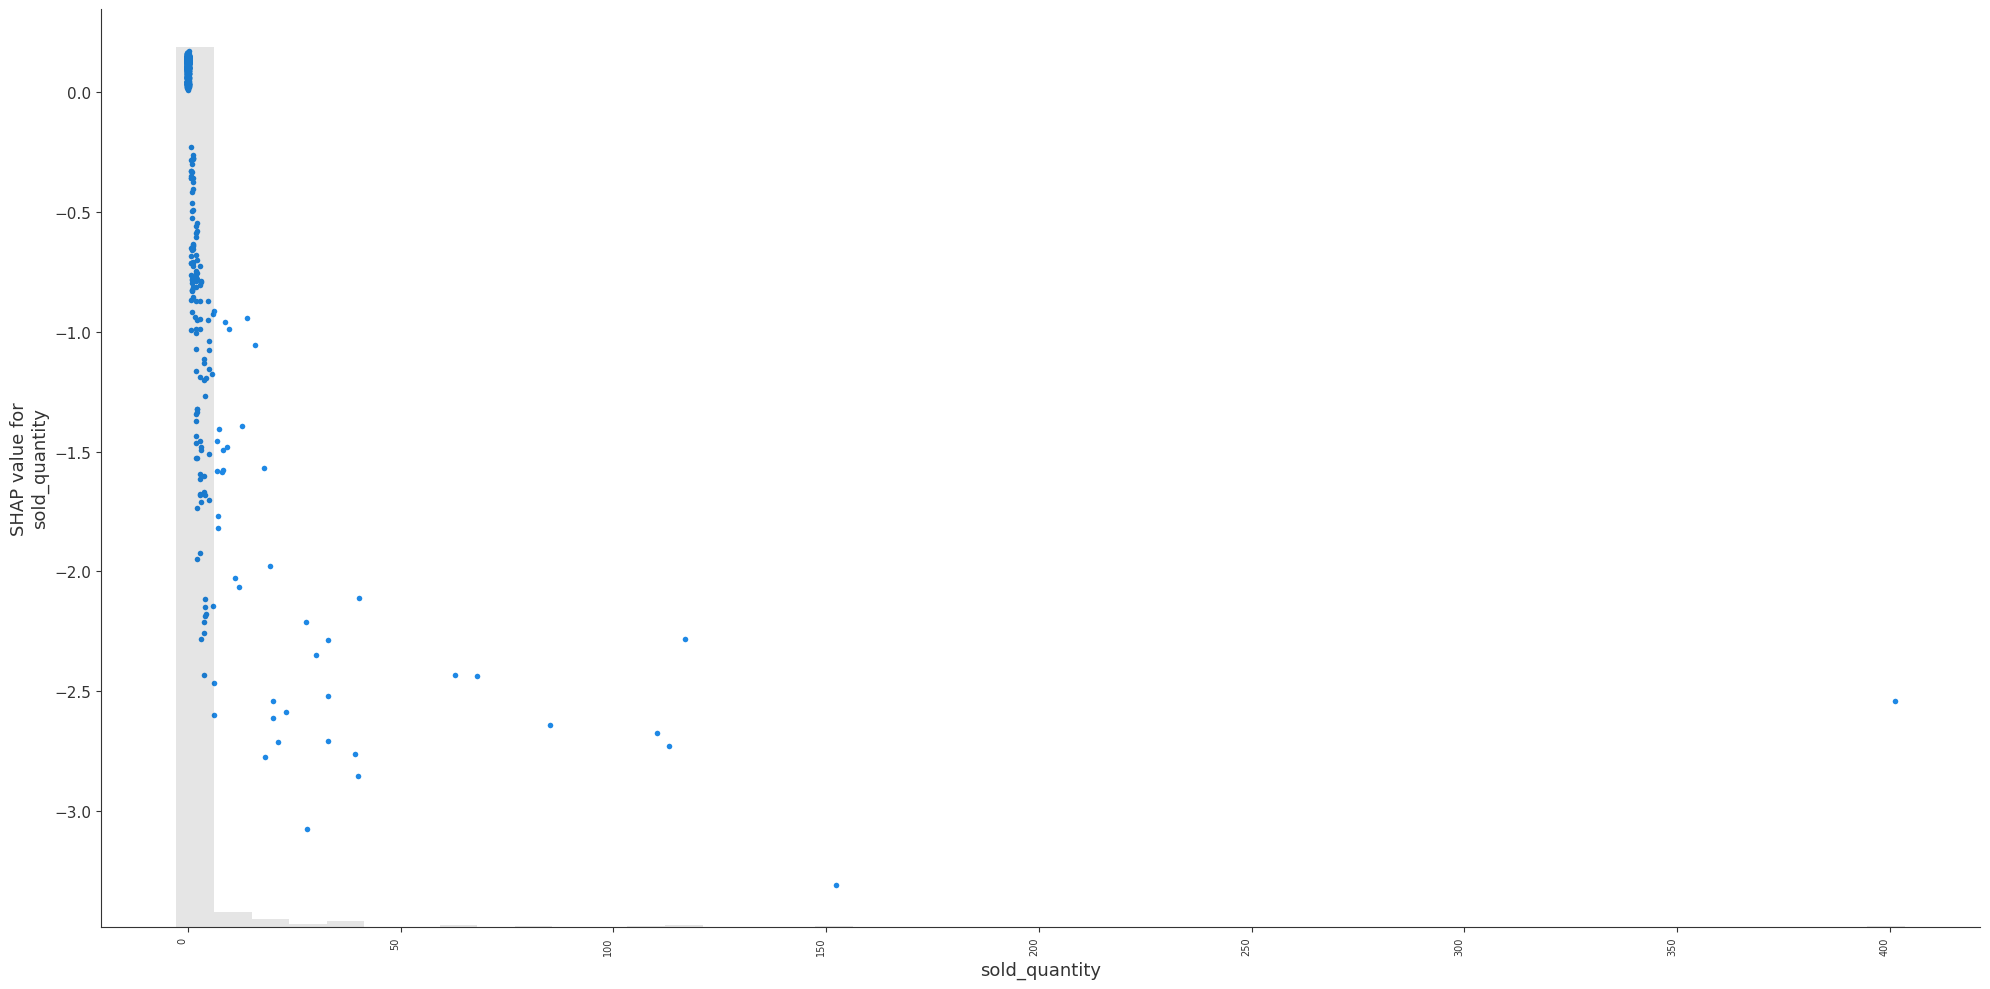

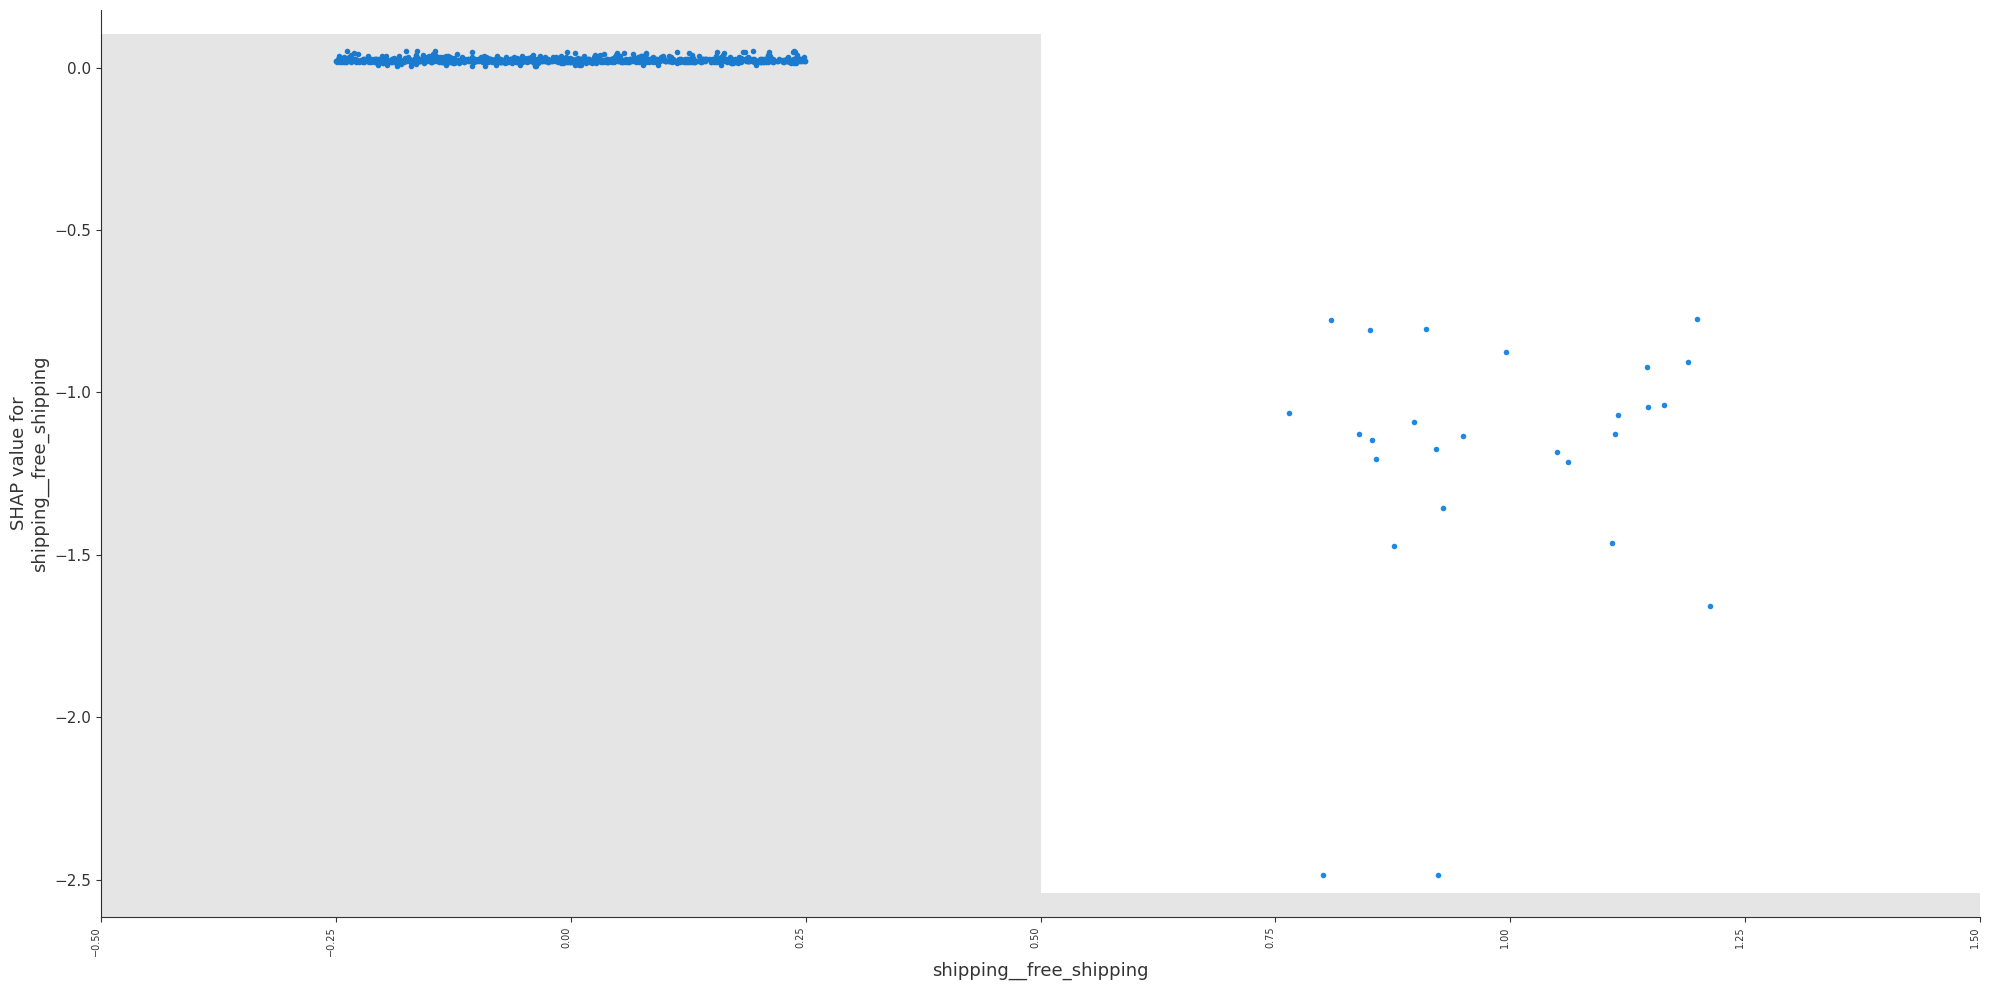

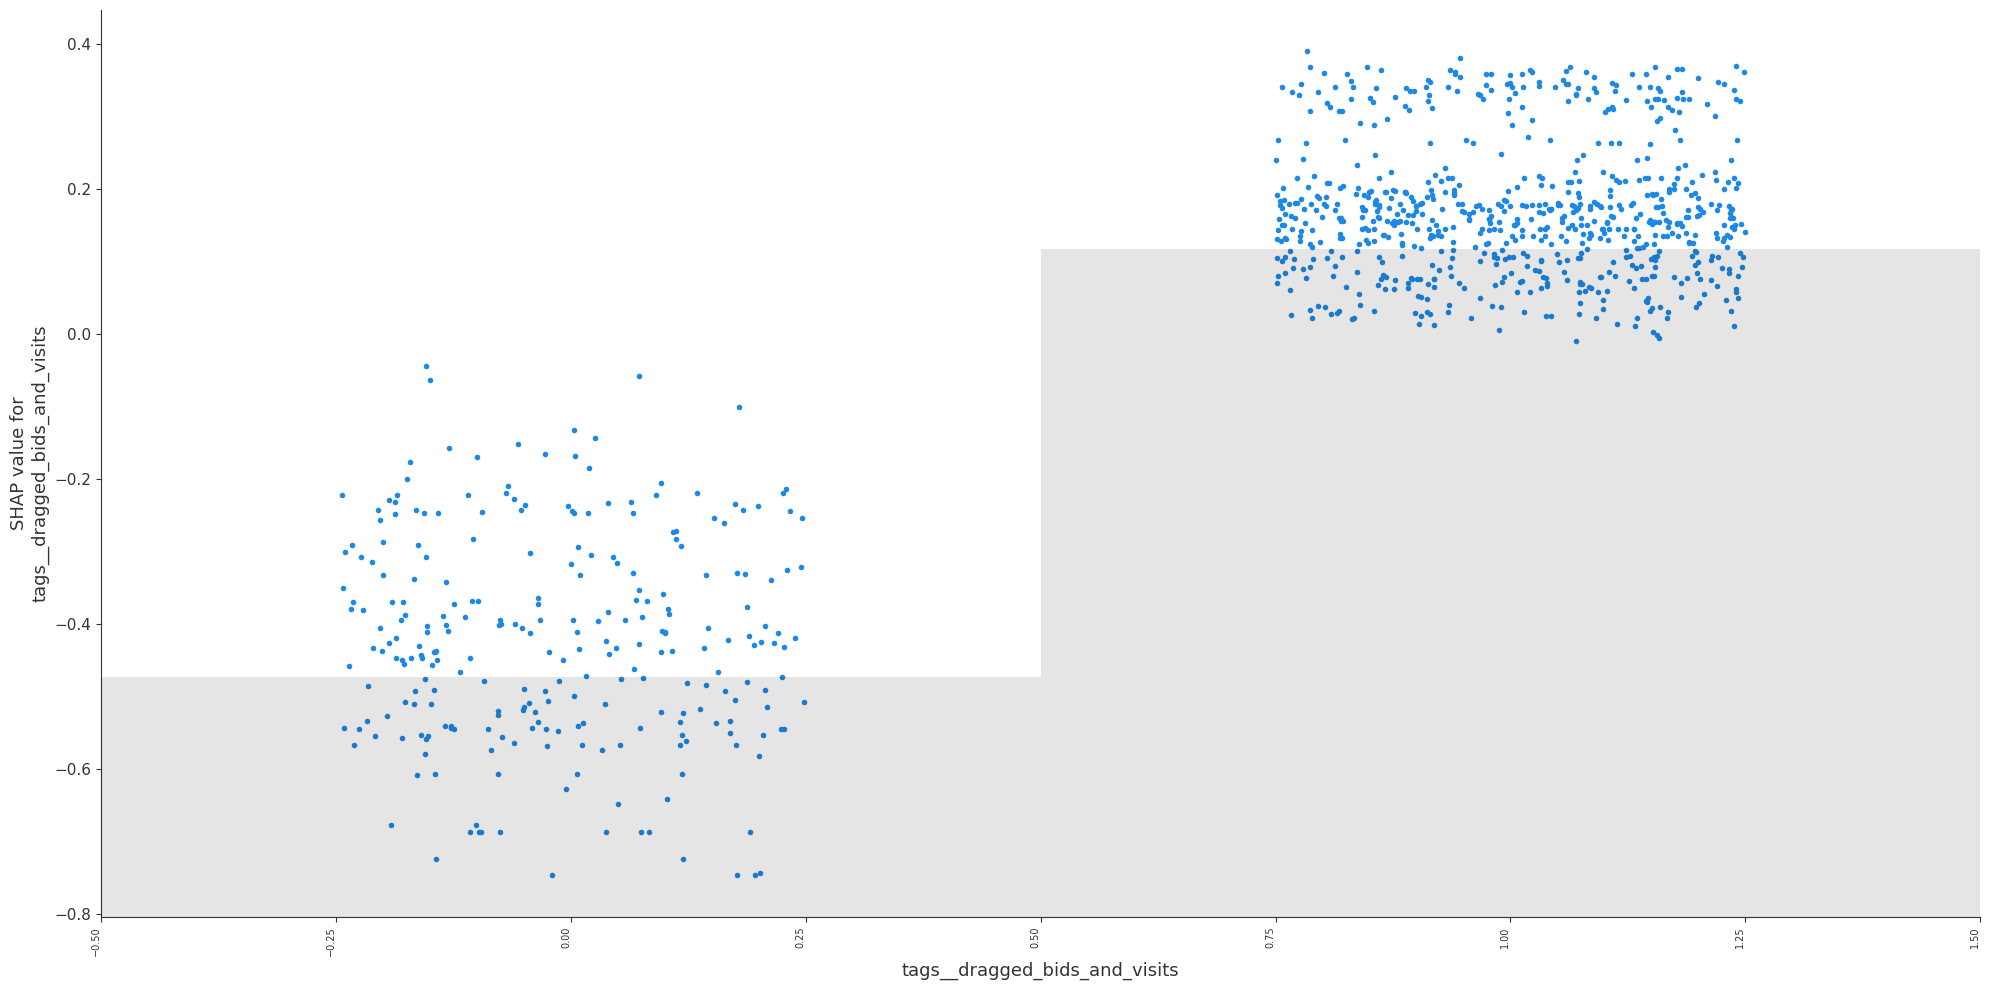

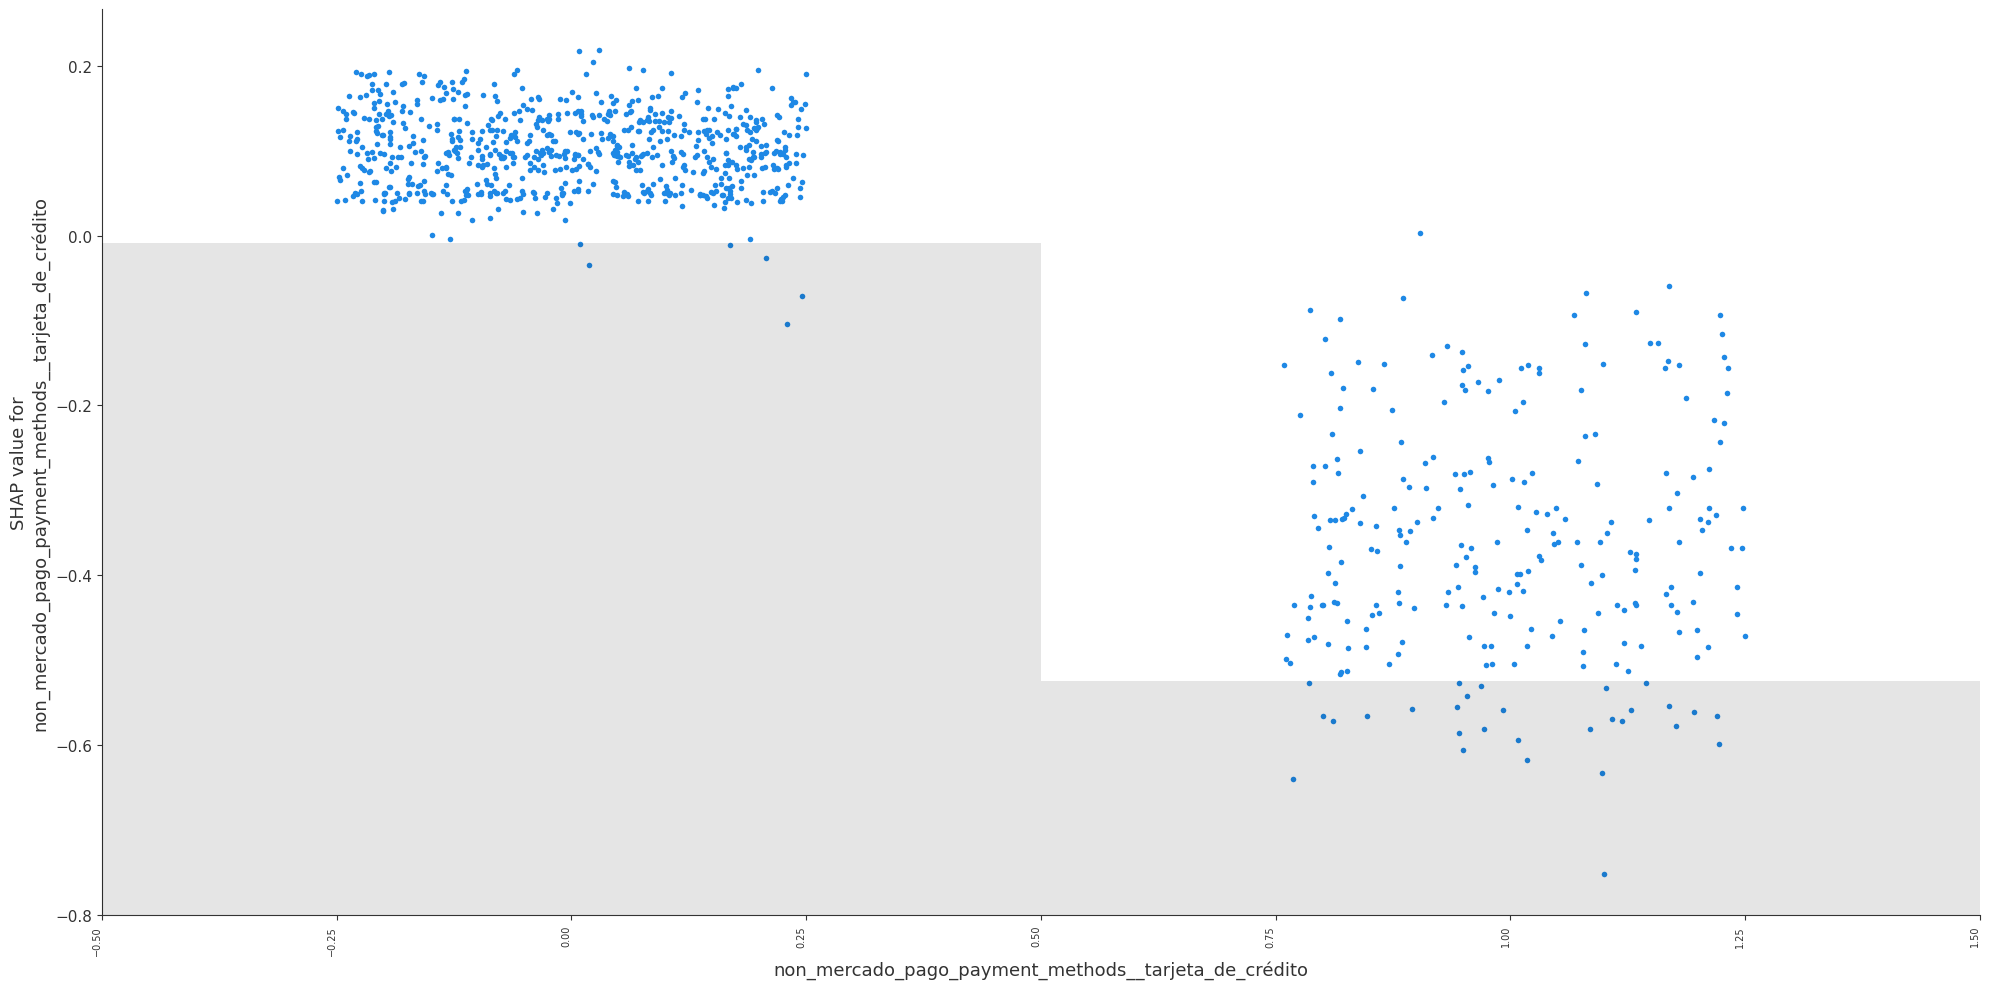

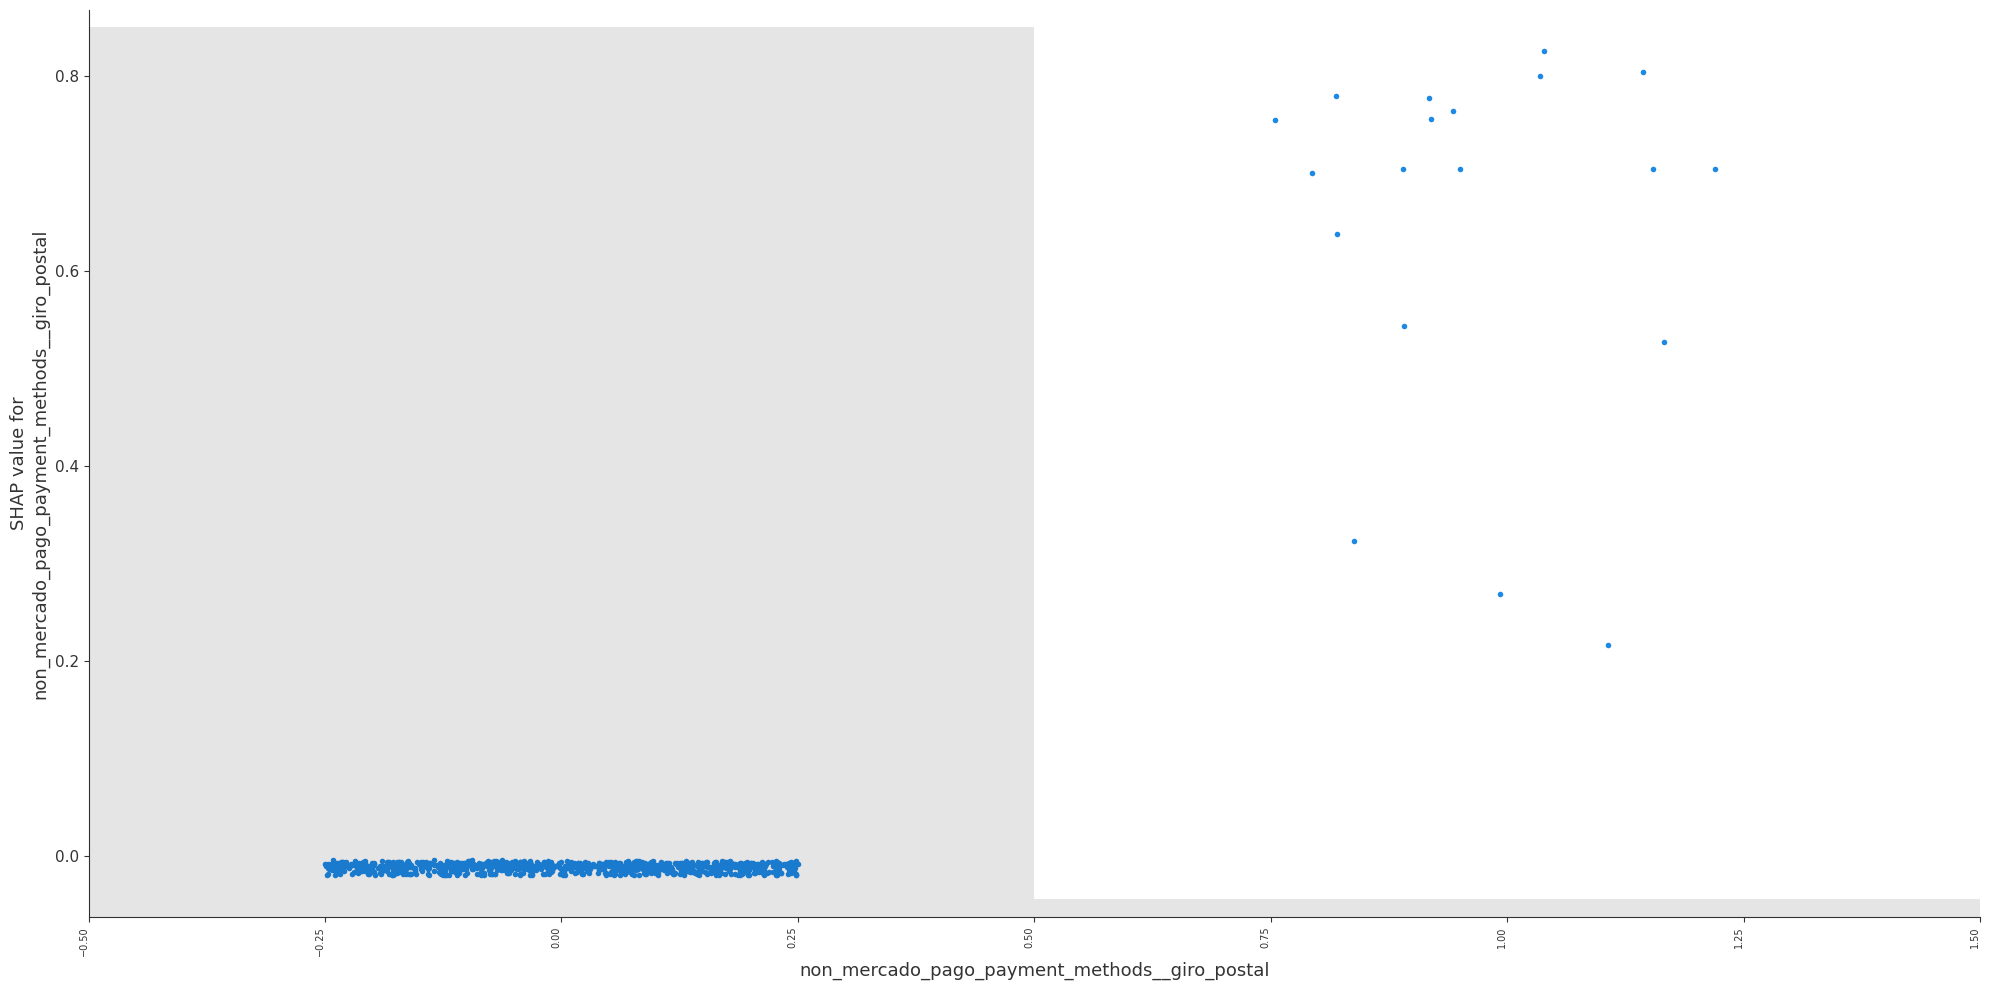

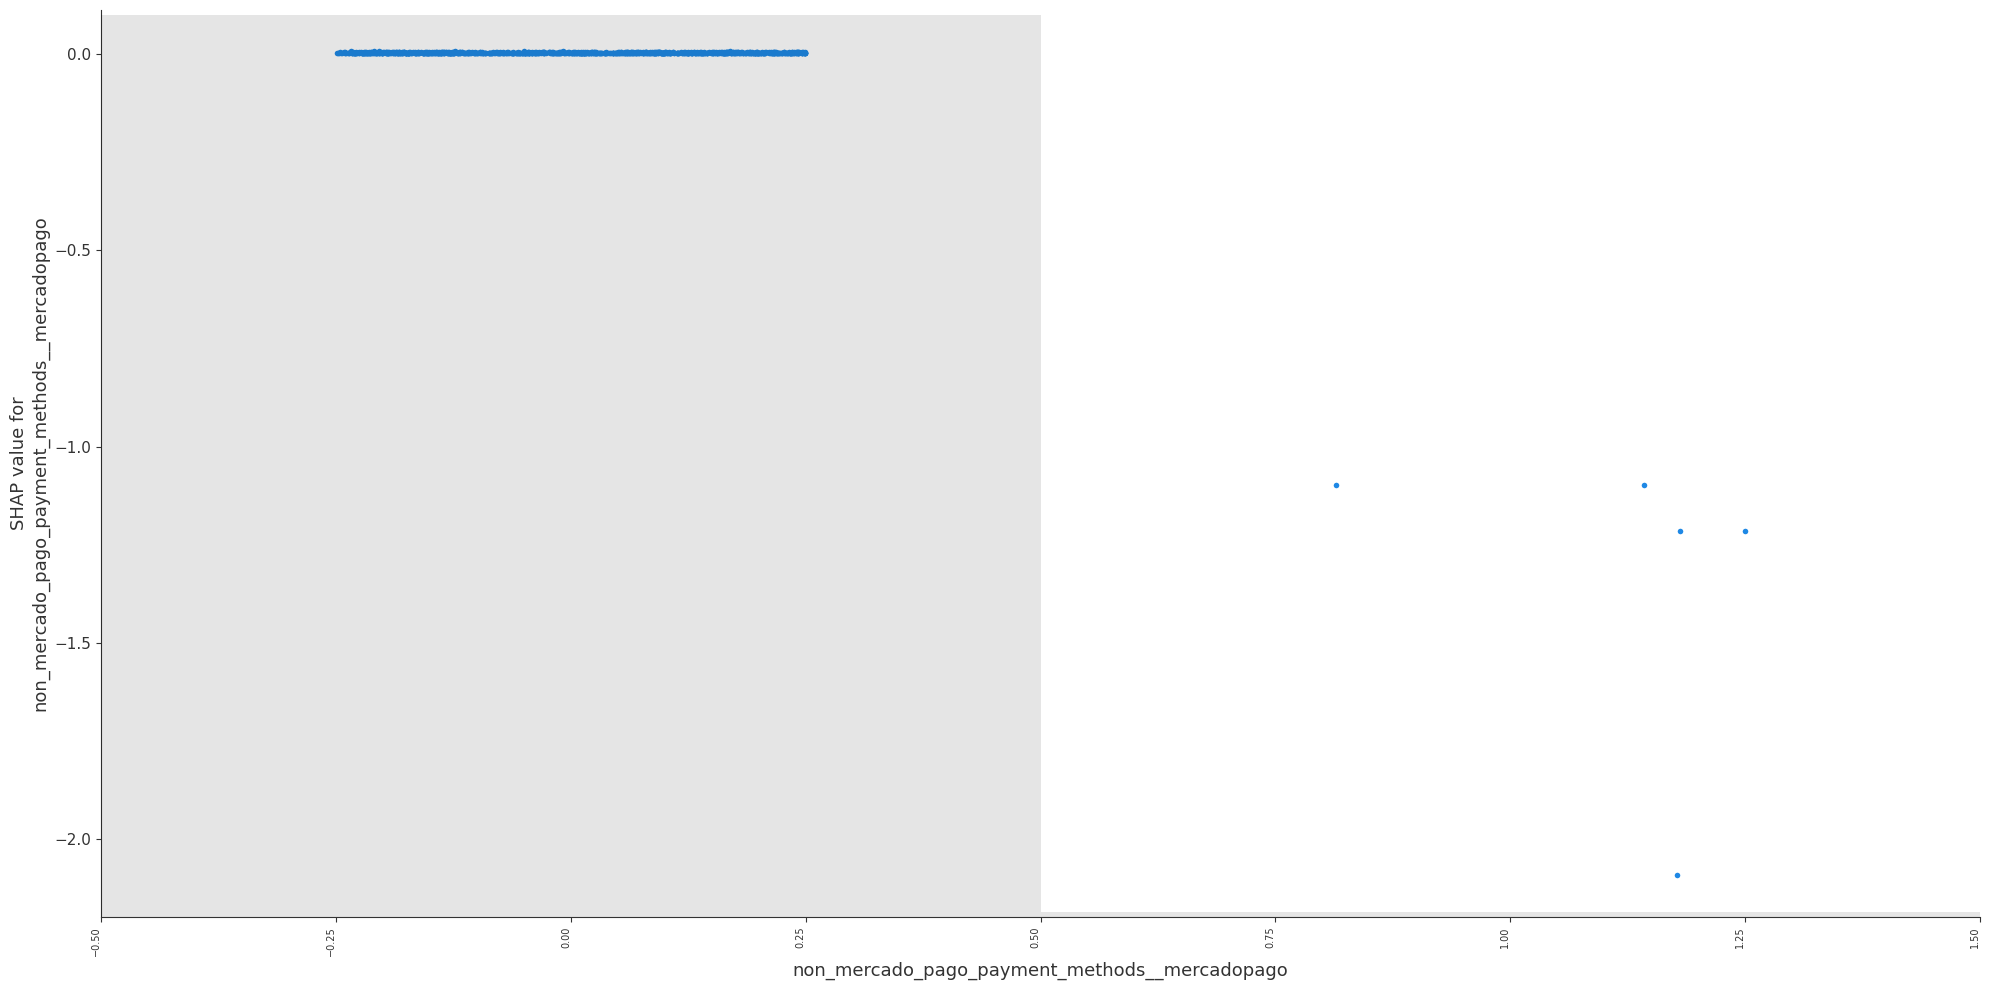

In [13]:
for var in X_shap.columns:
    shap.plots.scatter(shap_values=explanation[:, var], x_jitter=0.5, show=False)
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.xticks(rotation=90, ha='right', size=7)
    plt.tight_layout()
    plt.show()